# Μέρος Α - Bert sentiment classifier

In [ ]:
train_set_location = r'vaccine_train_set.csv' 
validation_set_location = r'vaccine_validation_set.csv'

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 8.3 MB/s 
     |████████████████████████████████| 67 kB 2.2 MB/s 
     |████████████████████████████████| 895 kB 31.3 MB/s 
     |████████████████████████████████| 596 kB 8.2 MB/s 
     |████████████████████████████████| 6.5 MB 30.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification
from torch.optim import Adam,AdamW
!pip install tweet-preprocessor
import preprocessor as p
!pip install emoji --upgrade
import emoji
import torch   
import torchtext
from torchtext.legacy import data   
import random
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import os

     |████████████████████████████████| 174 kB 9.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=f04a939b58439a963496ffecdf41bf1556bda949073398fd62689a1b5809210f
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
trainSet = pd.read_csv(train_set_location,index_col=0)  # read csv file and store it to a dataframe
validationSet = pd.read_csv(validation_set_location,index_col=0)  # read csv file and store it to a dataframe

## Data pre-processing

In [ ]:
###### DATA PRE-PROCESSING ####################################################################
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.NUMBER) # set tweet-preprocessor to remove urls, mentions and numbers

def clean_tweets(data,column):  # function that removes urls, mentions and numbers from all the tweets of the given dataframe
  for i,v in enumerate(data[column]): # for every tweet
      data.loc[i,column] = p.clean(v)
  return data

tweet_tokenizer = TweetTokenizer()   # initialize tweet tokenizer

stop_words = stopwords.words('english') # get english stop words

punctuations = list(string.punctuation) # get puncutations 
punctuations = punctuations + ['–','::','“','’','”','‘','`','...','``']  # add some extra puncutations

def removeEmojis(text): # function that converts emojis to the equivalent text
    text = emoji.demojize(text) # remove emojis
    return str(text) 

def removePuncutation(text):   # remove punctuation from the given text
    text = text.replace("-","")
    splitted = tweet_tokenizer.tokenize(text) # split the tweet into tokens
    new_text = []
    for word in splitted:  # for every token
      if word not in punctuations:    # keep it only if it is not a punctuation
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def removeStopWordsAndPuncs(text):  # remove stop-words and punctuation from the given text
    text = text.replace("-","")
    text = text.replace("::"," ")
    splitted = word_tokenize(text)  # split the tweet into tokens
    new_text = []
    for word in splitted:   # for every token
      if word not in stop_words and word not in punctuations: # keep it only if it is not a punctuation or stop_word
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def clean(text):    # clean the given tweet
    if(CONVERT_TO_LOWERCASE): # if it is enabled
      text = text.lower()  # convert all letters in to lowercase
    if(CLEAN_EMOJIS):
      text = removeEmojis(text)  # convert all emojis to the equivelent text
    if(CLEAN_STOPWORDS and CLEAN_PUNCUATIONS):
      text = removeStopWordsAndPuncs(text)    # remove all punctuation and stopwords
    elif(CLEAN_PUNCUATIONS):
      text = removePuncutation(text)    # remove all punctuation 
    return text

def cleanText(data,column):  # apply clean function to every tweet of the given dataframe
  data[column] = data[column].apply(clean)
  return data

# stemming
ps = SnowballStemmer("english") # intialize stemmer

def stemmTweet(text): # apply stemming to the given tweet
  return ' '.join([(ps.stem) for w \
                       in w_tokenizer.tokenize((text))])  # split the tweet into tokens and apply stemming to every token

def stem_data(data,column): # apply stemming into every tweet of the given dataframe
  data[column] = data[column].apply(stemmTweet)
  return data

lemmatizer = nltk.stem.WordNetLemmatizer()  # initialize Lemmatizer
w_tokenizer =  TweetTokenizer() # initialize tokenizer
 
def lemmatize_text(text): # apply lemmatization to the given tweet
  return ' '.join([(lemmatizer.lemmatize(w)) for w \
                       in word_tokenize((text))])  # split the tweet into tokens and apply lemmatization to every token

def lemmatize_data(data,column): # apply lemmatization into every tweet of the given dataframe
  data[column] = data[column].apply(lemmatize_text)
  return data   
###############################################################################################

CLEAN_ULR_MENTIONS_NUMBERS = True   # remove urls, mentions and numbers from tweets
CLEAN_STOPWORDS = True # remove stopwords from tweets
CLEAN_EMOJIS = True # convert emojis to the equivelent text
CLEAN_PUNCUATIONS = True  # remove punctuation from tweets
CONVERT_TO_LOWERCASE = True # convert all text to lowercase
LEMMATIZATION = True # apply lemmatization to the tweets
STEMMING = False   # apply stemming to the tweets
   

if(CLEAN_ULR_MENTIONS_NUMBERS):
  trainSet = clean_tweets(trainSet,'tweet') # remove urls, mentions, numbers from all the tweets in the train set
  validationSet = clean_tweets(validationSet,'tweet') # remove urls, mentions, numbers from all the tweets in the validation set
if(CLEAN_EMOJIS or CLEAN_STOPWORDS or CLEAN_PUNCUATIONS or CONVERT_TO_LOWERCASE):
  trainSet = cleanText(trainSet,'tweet')    # clean the tweets of the train set 
  validationSet = cleanText(validationSet,'tweet')    # clean the tweets of the validation set 
if(LEMMATIZATION):
  trainSet = lemmatize_data(trainSet,'tweet') # apply lemmatization to all the tweets of the train set
  validationSet = lemmatize_data(validationSet,'tweet')  # apply lemmatization to all the tweets of the validation set
if(STEMMING):
  trainSet = stem_data(trainSet,'tweet')   # apply stemming to all the tweets of the train set
  validationSet = stem_data(validationSet,'tweet')   # apply stemming to all the tweets of the validation set

X_train = list(trainSet['tweet']) # convert the tweets of the train set into a list
y_train = list(trainSet['label']) # convert the labels of the train set into a list

X_validation = list(validationSet['tweet']) # convert the tweets of the validation set into a list
y_validation = list(validationSet['label']) # convert the labels of the validation set into a list

## Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Initialize the tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X_train = [tokenizer(text,padding='max_length', max_length = 150) for text in X_train] # tokenize all the tweets of the training set
X_validation = [tokenizer(text,padding='max_length', max_length = 150) for text in X_validation] # tokenize all the tweets of the validation set

X_train_id = [tokenized['input_ids'] for tokenized in X_train]  # store all the input_ids of the training set into a list
X_train_mask = [tokenized['attention_mask'] for tokenized in X_train] # store all the attention_masks of the training set into a list
X_validation_id = [tokenized['input_ids'] for tokenized in X_validation]  # store all the input_ids of the validation set into a list
X_validation_mask = [tokenized['attention_mask'] for tokenized in X_validation] # store all the attention_masks of the validation set into a list

# convert all training data into tensors (input_ids, attention_masks and labels)
x_train_id_tensor = torch.tensor(X_train_id)
x_train_mask_tensor = torch.tensor(X_train_mask)
y_train_tensor = torch.tensor(y_train)
# convert all validation data into tensors (input_ids, attention_masks and labels)
x_validation_id_tensor = torch.tensor(X_validation_id)
x_validation_mask_tensor = torch.tensor(X_validation_mask)
y_validation_tensor = torch.tensor(y_validation)

## Finetuning

In [ ]:
set_seed(1234) # set seeds for data reprodusability
#define epochs
TRAINING_EPOCHS = 3

#Define Hyperparameters
learning_rate = 5e-6
batch_size = 32

# define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)
# define the loss function
loss_func = nn.CrossEntropyLoss()
# define the optimizer
optimizer = AdamW(model.parameters(), lr= learning_rate)

# use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
  model = model.cuda()
  loss_func = loss_func.cuda()

#Initialize dataloader for train set
train_dataset = torch.utils.data.TensorDataset(x_train_id_tensor, y_train_tensor,x_train_mask_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#Initialize dataloader for validation set
validation_dataset = torch.utils.data.TensorDataset(x_validation_id_tensor, y_validation_tensor,x_validation_mask_tensor)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def train_model(model,criterion,train_loader,validation_loader,optimizer,epochs = 200):
  train_loss = [] # store the train loss for every epoch
  valid_loss = []  # store the validation loss for every epoch
  for epoch in range(epochs):
    train_batch_losses = [] # store the loss of every batch of the train set
    validation_batch_losses = [] # store the loss of every batch of the validation set
    model.train() # set the model to training mode
    y_total_predict_train = []   # store the predictions of the the train set
    y_total_train = []     # store the labels of the the train set
    for x_batch, y_batch, mask in train_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      mask = mask.to(device)
      #Delete previously stored gradients
      optimizer.zero_grad()
      z = model(x_batch, token_type_ids=None, attention_mask=mask, labels=y_batch)
      z = z[1] # get the output logits
      loss = criterion(z, y_batch)  # compute the train loss
      train_batch_losses.append(loss.data.item()) # store the train loss of the current batch
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),5.0) # perform gradient clipping
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      _, y_pred_tags = torch.max(z, dim = 1)  # get the prediction based on the maximum posibility
      y_total_predict_train = y_total_predict_train+ list(y_pred_tags.cpu()) # store the predictions of the current batch
      y_total_train = y_total_train + (list(y_batch.cpu().detach().numpy())) # store the labels of the current batch
    correct = 0
    count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    with torch.no_grad():
      for x_batch, y_batch, mask in validation_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mask = mask.to(device)
        z = model(x_batch, token_type_ids=None, attention_mask=mask, labels=y_batch)
        z = z[1]  # get the output logits
        loss = criterion(z, y_batch)   # compute the validation loss
        validation_batch_losses.append(loss.data.item())   # store the validation loss of the current batch
        _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
        correct += (label==y_batch).sum().item()    # compute how many corect preditions were made
        count += len(y_batch)
        y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
        y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch
    accuracy = 100*(correct/(count))  # compute validation accuracy based on the correct predictions
    current_train_loss = sum(train_batch_losses)/len(train_loader)  #compute the train loss of this epoch
    train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
    current_valid_loss = sum(validation_batch_losses)/len(validation_loader)   #compute the validation loss of this epoch
    valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
    f1_score_train = f1_score(y_total_train,y_total_predict_train,average='weighted')# compure train f1-score
    f1_score_valid = f1_score(y_total_valid,y_total_predict_valid,average='weighted') # compure validation f1-score
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Accuracy = {accuracy:.4f} | Train-f1 = {f1_score_train:.4f} | Valid-F1 = {f1_score_valid:.4f}")
  return model,train_loss,valid_loss

# train the model
trained_model, train_loss,valid_loss = train_model(model,loss_func,train_loader,validation_loader,optimizer,TRAINING_EPOCHS)

Epoch   0: Train Loss = 0.79033 | Validation Loss = 0.67909 | Accuracy = 70.6836 | Train-f1 = 0.6156 | Valid-F1 = 0.6912
Epoch   1: Train Loss = 0.65779 | Validation Loss = 0.64380 | Accuracy = 73.0500 | Train-f1 = 0.7125 | Valid-F1 = 0.7257
Epoch   2: Train Loss = 0.59623 | Validation Loss = 0.62333 | Accuracy = 73.7949 | Train-f1 = 0.7523 | Valid-F1 = 0.7377


## Model Evaluation

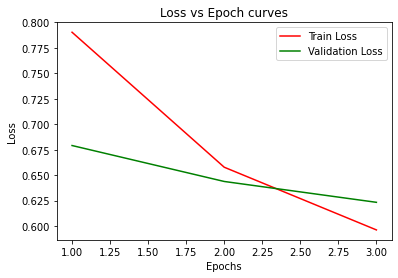

 Accuracy: 73.79%
 f1 score: 73.77%
 Precision: 73.94%
 Recall: 73.79%
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1065
           1       0.58      0.52      0.55       296
           2       0.69      0.76      0.72       921

    accuracy                           0.74      2282
   macro avg       0.70      0.69      0.69      2282
weighted avg       0.74      0.74      0.74      2282



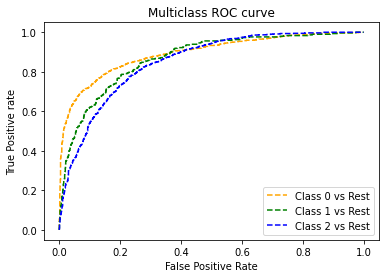

In [ ]:
def plot_loss_curves(t_loss,v_loss,epochs = 100):
  # function that plots the loss vs epochs curves
  x = list(range(1,epochs+1))
  plt.plot(x, t_loss, 'r',label='Train Loss')
  plt.plot(x, v_loss, 'g',label='Validation Loss')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch curves')
  plt.show()

# plot the loss vs epochs curves
plot_loss_curves(train_loss,valid_loss,TRAINING_EPOCHS) 

with torch.no_grad():
  model.eval()   # set the model to evaluation mode
  y_total_valid = []   # store the predictions of the the validation set
  y_total_predict_valid = []      # store the labels of the the validation set
  y_output = []
  for x_batch, y_batch, mask in validation_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    mask = mask.to(device) # use gpu
    z = model(x_batch, token_type_ids=None, attention_mask=mask, labels=y_batch)
    z = z[1]
    _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
    y_output = y_output + list(z.cpu().detach().numpy())
    y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
    y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

y_output = np.array(y_output)
n_class = 3  # number of classes/labels

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_total_valid, y_output[:,i], pos_label=i)
    
# plotting the ROC curves
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

y_pred_tags = y_total_predict_valid
accuracy_countVec = accuracy_score(y_total_valid,y_pred_tags)  # accuracy metric
f1_score_countVec = f1_score(y_total_valid,y_pred_tags,average='weighted') # f1_score metric
print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
print(" f1 score: %.2f%%" %(f1_score_countVec*100))
print(' Precision: %.2f%%' % (precision_score(y_total_valid, y_pred_tags,average='weighted')*100)) # precision
print(' Recall: %.2f%%' % (recall_score(y_total_valid, y_pred_tags,average='weighted')*100)) # recall
print(classification_report(y_total_valid, y_pred_tags))

# ΜΕΡΟΣ Β & Γ
Το μέρος Β (Bert finetuning for SQuAD dataset) αποτελεί υποερώτημα του μέρους Γ.
Έτσι παρουσιάζονται μαζί.

Αρχικά στην παράγραφο [Datasets Creation](#data_creation) δημιουργούνται τα εξής 5 datasets:
  - SQuAD 2.0
  - Trivia QA
  - News QA
  - Natural Questions (NQ)
  - Quac

Τα datasets (εκτός του SQuAD) μετατρέπονται στο ίδιο format με τα αρχεία του SQuAD.

Στην συνέχεια, για κάθε ένα dataset πραγματοποιείται:
 - Finetuning του μοντέλου Bert χρησιμοποιώντας το training set του συγκεκριμένου dataset.
 - Evaluation του μοντέλου χρησιμοποιώντας το dev set του ίδιου dataset.
 - Evaluation του μοντέλου χρησιμοποιώντας τα dev sets των υπόλοιπων 4 datasets.

Περισσότερες λεπτομέρειες εξηγούνται στο README.

Όσον αφορά το μέρος Β της εργασίας, παρουσιάζεται στις παραγράφους:

- [SQUAD FINETUNE](#squad_finetune) (Bert finetuning on SQuAD dataset)
- [SQuAD fined-tuned model evaluation](#squad_evaluation) (evaluation of the finetuned model)

<a name="data_creation"></a>
# Datasets Creation
Download and convert all datastets to SQuAD format

## SQuAD dataset creation
Download of SQuAD dataset.

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2022-03-04 11:22:03--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   184MB/s    in 0.2s    

2022-03-04 11:22:03 (184 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2022-03-04 11:22:04--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

## TriviaQA dataset creation
Download of TriviaQA dataset and tranformation to SQuAD format.

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 14.1 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
     |████████████████████████████████| 6.5 MB 50.7 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import json
from transformers import DistilBertTokenizerFast, BertTokenizerFast, DistilBertForQuestionAnswering, BertForQuestionAnswering
from transformers import AdamW
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
!tar -xzf triviaqa-rc.tar.gz

--2022-03-03 10:59:44--  https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
Resolving nlp.cs.washington.edu (nlp.cs.washington.edu)... 128.208.3.120, 2607:4000:200:12::78
Connecting to nlp.cs.washington.edu (nlp.cs.washington.edu)|128.208.3.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2665779500 (2.5G) [application/x-gzip]
Saving to: ‘triviaqa-rc.tar.gz’

triviaqa-rc.tar.gz  100%[===================>]   2.48G  19.6MB/s    in 2m 24s  

2022-03-03 11:02:09 (17.7 MB/s) - ‘triviaqa-rc.tar.gz’ saved [2665779500/2665779500]



In [ ]:
# UTILS 
def add_triple_data(datum, page, domain):
    qad = {'Source': domain}
    for key in ['QuestionId', 'Question', 'Answer']:
        qad[key] = datum[key]
    for key in page:
        qad[key] = page[key]
    return qad


def get_qad_triples(data):
    qad_triples = []
    for datum in data['Data']:
        for key in ['EntityPages', 'SearchResults']:
            for page in datum.get(key, []):
                qad = add_triple_data(datum, page, key)
                qad_triples.append(qad)
    return qad_triples


def get_file_contents(filename, encoding='utf-8'):
    with open(filename, encoding=encoding) as f:
        content = f.read()
    return content

def read_json(filename, encoding='utf-8'):
    contents = get_file_contents(filename, encoding=encoding)
    return json.loads(contents)

def read_clean_part(datum):
    for key in ['EntityPages', 'SearchResults']:
        new_page_list = []
        for page in datum.get(key, []):
            if page['DocPartOfVerifiedEval']:
                new_page_list.append(page)
        datum[key] = new_page_list
    assert len(datum['EntityPages']) + len(datum['SearchResults']) > 0
    return datum


def read_triviaqa_data(qajson):
    data = read_json(qajson)
    # read only documents and questions that are a part of clean data set
    if data['VerifiedEval']:
        clean_data = []
        for datum in data['Data']:
            if datum['QuestionPartOfVerifiedEval']:
                if data['Domain'] == 'Web':
                    datum = read_clean_part(datum)
                clean_data.append(datum)
        data['Data'] = clean_data
    return data

def get_question_doc_string(qid, doc_name):
    return '{}--{}'.format(qid, doc_name)

In [ ]:
import os
import argparse
import json
import nltk
# from utils.convert_to_squad_format import get_qad_triples
# from utils.utils import get_file_contents
# from utils.dataset_utils import read_triviaqa_data, get_question_doc_string


def answer_index_in_document(answer, document):
    answer_list = answer['Aliases'] + answer['NormalizedAliases']
    for answer_string_in_doc in answer_list:
        index = document.find(answer_string_in_doc)
        if index != -1:
            return answer_string_in_doc, index
    return answer['NormalizedValue'], -1


def select_relevant_portion(text):
    paras = text.split('\n')
    selected = []
    done = False
    for para in paras:
        sents = sent_tokenize.tokenize(para)
        for sent in sents:
            words = nltk.word_tokenize(sent)
            for word in words:
                selected.append(word)
                if len(selected) >= 800:
                    done = True
                    break
            if done:
                break
        if done:
            break
        selected.append('\n')
    st = ' '.join(selected).strip()
    return st


def triviaqa_to_squad_format(triviaqa_file, data_dir, output_file):
    triviaqa_json = read_triviaqa_data(triviaqa_file)
    qad_triples = get_qad_triples(triviaqa_json)

    data = []

    for triviaqa_example in qad_triples:
        question_text = triviaqa_example['Question']
        text = get_file_contents(os.path.join(data_dir, triviaqa_example['Filename']), encoding='utf-8')
        context = select_relevant_portion(text)

        para = {'context': context, 'qas': [{'question': question_text, 'answers': []}]}
        data.append({'paragraphs': [para]})
        qa = para['qas'][0]
        qa['id'] = get_question_doc_string(triviaqa_example['QuestionId'], triviaqa_example['Filename'])
        qa['is_impossible'] = True
        ans_string, index = answer_index_in_document(triviaqa_example['Answer'], context)

        if index != -1:
            qa['answers'].append({'text': ans_string, 'answer_start': index})
            qa['is_impossible'] = False

    triviaqa_as_squad = {'data': data, 'version': '2.0'}

    with open(output_file, 'w', encoding='utf-8') as outfile:
        json.dump(triviaqa_as_squad, outfile, indent=2, sort_keys=True, ensure_ascii=False)

sent_tokenize = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
triviaqa_file_train = 'qa/wikipedia-train.json'
data_dir = 'evidence/wikipedia/'
output_file_train = 'triviaqa_train_SquadFormat.json'
triviaqa_to_squad_format(triviaqa_file_train, data_dir, output_file_train)

In [ ]:
triviaqa_file_dev = 'qa/wikipedia-dev.json'
data_dir = 'evidence/wikipedia/'
output_file_dev = 'triviaqa_dev_SquadFormat.json'
triviaqa_to_squad_format(triviaqa_file_dev, data_dir, output_file_dev)

## NewsQA dataset creation
Download of NewsQA dataset and tranformation to SQuAD format.

In [ ]:
!git clone https://github.com/Maluuba/newsqa

Cloning into 'newsqa'...
remote: Enumerating objects: 132, done.
remote: Total 132 (delta 0), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (132/132), 599.31 KiB | 1.37 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
!wget https://nlp.stanford.edu/software/stanford-postagger-2015-12-09.zip

--2022-03-01 19:51:32--  https://nlp.stanford.edu/software/stanford-postagger-2015-12-09.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-postagger-2015-12-09.zip [following]
--2022-03-01 19:51:32--  https://downloads.cs.stanford.edu/nlp/software/stanford-postagger-2015-12-09.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25169032 (24M) [application/zip]
Saving to: ‘stanford-postagger-2015-12-09.zip’

stanford-postagger- 100%[===================>]  24.00M  23.9MB/s    in 1.0s    

2022-03-01 19:51:33 (23.9 MB/s) - ‘stanford-postagger-2015-12-09.zip’ saved [25169032/25169032]



In [ ]:
!unzip /content/stanford-postagger-2015-12-09.zip

In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
!conda create --name newsqa python=2.7 "pandas>=0.19.2"

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.4
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /usr/local/envs/newsqa

  added / updated specs: 
    - pandas[version='>=0.19.2']
    - python=2.7


The f

In [ ]:
!python2.7 newsqa/maluuba/newsqa/data_generator.py

[INFO] 2022-03-01 19:53:21,484 - data_processing.py::__init__
Loading dataset from `/content/newsqa/maluuba/newsqa/newsqa-data-v1.csv`...
[INFO] 2022-03-01 19:53:21,485 - data_processing.py::load_combined
Loading data from `/content/newsqa/maluuba/newsqa/newsqa-data-v1.csv`...
[INFO] 2022-03-01 19:53:22,167 - data_processing.py::__init__
Loading stories from `/content/newsqa/maluuba/newsqa/cnn_stories.tgz`...
Getting story texts: 100% 12.7k/12.7k [00:13<00:00, 974 stories/s]    
Setting story texts: 100% 120k/120k [00:03<00:00, 36.4k questions/s] 
[INFO] 2022-03-01 19:53:38,565 - data_processing.py::__init__
Done loading dataset.
[INFO] 2022-03-01 19:53:38,675 - data_processing.py::dump
Packaging dataset to `combined-newsqa-data-v1.json`.
Building json: 100% 120k/120k [00:06<00:00, 18.0k questions/s]
[INFO] 2022-03-01 19:53:52,757 - data_processing.py::dump
Packaging dataset to `combined-newsqa-data-v1.csv`.
[INFO] 2022-03-01 19:54:04,776 - data_processing.py::load_combined
Loading dat

In [ ]:
!python2.7 -m unittest discover ./newsqa

[INFO] 2022-03-01 20:02:13,041 - data_processing.py::__init__
Loading dataset from `/content/newsqa/maluuba/newsqa/newsqa-data-v1.csv`...
[INFO] 2022-03-01 20:02:13,041 - data_processing.py::load_combined
Loading data from `/content/newsqa/maluuba/newsqa/newsqa-data-v1.csv`...
[INFO] 2022-03-01 20:02:13,712 - data_processing.py::__init__
Loading stories from `/content/newsqa/maluuba/newsqa/cnn_stories.tgz`...
Getting story texts: 100% 12.7k/12.7k [00:13<00:00, 974 stories/s]    
Setting story texts: 100% 120k/120k [00:03<00:00, 36.0k questions/s] 
[INFO] 2022-03-01 20:02:30,140 - data_processing.py::__init__
Done loading dataset.
Checking for possible corruption: 100% 120k/120k [00:01<00:00, 105k questions/s]
.[INFO] 2022-03-01 20:02:31,400 - data_processing.py::dump
Packaging dataset to `/content/newsqa/combined-newsqa-data-v1.json`.
Building json: 100% 120k/120k [00:06<00:00, 19.5k questions/s] 
Checking for possible corruption: 100% 12.7k/12.7k [00:00<00:00, 15.3k stories/s]
Gatheri

In [ ]:
import pandas as pd
import re
import uuid
import json
import argparse

def answer_text(story_text, answer_token_ranges):
    story_text_list = story_text.split()
    if answer_token_ranges:
        token_range = list(map(int, re.split(':|,', answer_token_ranges)))[0:2]
        answer = ' '.join(story_text_list[slice(token_range[0], token_range[1])])
        return answer


def answer_start(story_text, answer_text):
    if answer_text:
        return story_text.find(answer_text)
    else:
        return -1

def newsqa_to_squad(newsqa_file, output_file):
    newsqa = pd.read_csv(newsqa_file)
    newsqa['answer_text'] = newsqa[['story_text', 'answer_token_ranges']].apply(lambda x: answer_text(*x), axis=1)
    newsqa['answer_start'] = newsqa[['story_text', 'answer_text']].apply(lambda x: answer_start(*x), axis=1)
    newsqa['id'] = newsqa['story_id'].apply(lambda x: str(uuid.uuid4().hex))
    newsqa = newsqa[['id', 'story_text', 'question', 'answer_text', 'answer_start']]
    newsqa_json = newsqa.to_json(orient='records')
    newsqa_json = json.loads(newsqa_json)

    data = []

    for newsqa_example in newsqa_json:
        question_text = newsqa_example['question']
        context = newsqa_example['story_text']

        para = {'context': context, 'qas': [{'question': question_text, 'answers': []}]}
        data.append({'paragraphs': [para]})
        qa = para['qas'][0]
        qa['id'] = newsqa_example['id']
        qa['is_impossible'] = True

        if newsqa_example['answer_start'] != -1:
            ans_string = newsqa_example['answer_text']
            index = newsqa_example['answer_start']
            qa['answers'].append({'text': ans_string, 'answer_start': index})
            qa['is_impossible'] = False

    newsqa_as_squad = {'data': data, 'version': '2.0'}

    with open(output_file, 'w', encoding='utf-8') as outfile:
        json.dump(newsqa_as_squad, outfile, indent=2, sort_keys=True, ensure_ascii=False)

In [ ]:
triviaqa_file_train = 'split_data/train.csv'
output_file_train = 'newsqa_train_SquadFormat.json'
newsqa_to_squad(triviaqa_file_train, output_file_train)

In [ ]:
triviaqa_file_dev = 'split_data/dev.csv'
output_file_dev = 'newsqa_dev_SquadFormat.json'
newsqa_to_squad(triviaqa_file_dev, output_file_dev)

## Natural Questions (NQ) dataset creation
Download of NQ dataset and tranformation to SQuAD format.

In [ ]:
!gsutil -m cp -R gs://natural_questions/v1.0 .

Copying gs://natural_questions/v1.0/dev/nq-dev-02.jsonl.gz...
Copying gs://natural_questions/v1.0/dev/nq-dev-03.jsonl.gz...
Copying gs://natural_questions/v1.0/dev/nq-dev-00.jsonl.gz...
Copying gs://natural_questions/v1.0/dev/nq-dev-04.jsonl.gz...
Copying gs://natural_questions/v1.0/sample/nq-train-sample.jsonl.gz...
Copying gs://natural_questions/v1.0/LICENSE.txt...
Copying gs://natural_questions/v1.0/sample/nq-dev-sample.jsonl.gz...
Copying gs://natural_questions/v1.0/README.txt...
Copying gs://natural_questions/v1.0/dev/nq-dev-01.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-00.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-01.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-02.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-03.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-04.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-05.jsonl.gz...
Copying gs://natural_questions/v1.0/train/nq-train-06

In [ ]:
import json
import argparse
import gzip
import glob
import numpy as np
from bs4 import BeautifulSoup


def has_long_answer(nq_example):
    if len(nq_example['annotations']) == 1:
        annotation = nq_example['annotations'][0]
        return annotation['long_answer']['start_byte'] >= 0
    else:
        return sum([annotation['long_answer']['start_byte'] >= 0 for annotation in nq_example['annotations']]) >= 2


def has_short_answer(nq_example):
    if len(nq_example['annotations']) == 1:
        annotation = nq_example['annotations'][0]
        return annotation['short_answers'] or annotation['yes_no_answer'] != 'NONE'
    else:
        return sum([bool(annotation['short_answers']) or annotation['yes_no_answer'] != 'NONE'
                    for annotation in nq_example['annotations']]) >= 2


def render_answer(nq_example, start_byte, end_byte):
    html = nq_example['document_html'].encode('utf-8')
    answer_text = BeautifulSoup(html[start_byte:end_byte].decode('utf-8'), features='lxml').get_text()
    return answer_text


def get_long_answer(nq_example):
    if has_long_answer(nq_example):
        long_answers = [a['long_answer'] for a in nq_example['annotations'] if a['long_answer']['start_byte'] >= 0]
        long_answer_bounds = [(la['start_byte'], la['end_byte']) for la in long_answers]
        long_answer_counts = [long_answer_bounds.count(la) for la in long_answer_bounds]
        long_answer = long_answers[np.argmax(long_answer_counts)]
        html_tag = nq_example['document_tokens'][long_answer['end_token'] - 1]['token']
        if html_tag == '</P>':
            long_answer_text = render_answer(nq_example, long_answer['start_byte'], long_answer['end_byte'])
            return long_answer_text
    return None


def get_short_answers(nq_example):
    if has_short_answer(nq_example):
        short_answers = [a['short_answers'] for a in nq_example['annotations'] if a['short_answers']]
        short_answers_texts = [
            ', '.join([render_answer(nq_example, s['start_byte'], s['end_byte']) for s in short_answer])
            for short_answer in short_answers]
        short_answers_texts = set(short_answers_texts)
        return short_answers_texts
    return None


def nq_to_squad_format(nq_dir, output_file):
    data = []
    for filename in glob.glob(nq_dir + '/*.gz'):
        with gzip.open(filename, 'r') as f:
            for line in f:
                nq_example = json.loads(line)
                long_answer_text = get_long_answer(nq_example)

                if long_answer_text:
                    question_text = nq_example['question_text']
                    context = long_answer_text
                    para = {'context': context, 'qas': [{'question': question_text, 'answers': []}]}
                    data.append({'paragraphs': [para]})
                    qa = para['qas'][0]
                    qa['id'] = str(nq_example['example_id'])
                    qa['is_impossible'] = True
                    short_answer_texts = get_short_answers(nq_example)

                    if short_answer_texts:
                        for ans_string in short_answer_texts:
                            index = context.find(ans_string)
                            if index != -1:
                                qa['answers'].append({'text': ans_string, 'answer_start': index})
                                qa['is_impossible'] = False

    nq_as_squad = {'data': data, 'version': '2.0'}

    with open(output_file, 'w', encoding='utf-8') as outfile:
        outfile.write(json.dumps(nq_as_squad, indent=2, sort_keys=True, ensure_ascii=False))

In [ ]:
nq_to_squad_format('/content/v1.0/train', 'nq_train.json')

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.example.com/index.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
nq_to_squad_format('/content/v1.0/dev', 'nq_dev.json')

## Quac dataset creation
Download of Quac dataset and tranformation to SQuAD format.

In [ ]:
!wget https://s3.amazonaws.com/my89public/quac/train_v0.2.json
!wget https://s3.amazonaws.com/my89public/quac/val_v0.2.json

--2022-03-06 20:36:02--  https://s3.amazonaws.com/my89public/quac/train_v0.2.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.171.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.171.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68114819 (65M) [application/json]
Saving to: ‘train_v0.2.json’

train_v0.2.json     100%[===================>]  64.96M  34.6MB/s    in 1.9s    

2022-03-06 20:36:05 (34.6 MB/s) - ‘train_v0.2.json’ saved [68114819/68114819]

--2022-03-06 20:36:06--  https://s3.amazonaws.com/my89public/quac/val_v0.2.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.171.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.171.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8929167 (8.5M) [application/json]
Saving to: ‘val_v0.2.json’

val_v0.2.json       100%[===================>]   8.51M  15.0MB/s    in 0.6s    

2022-03-06 20:36:07 (15.0 MB/s) - ‘val_v0.2.json’ saved [8929167/8929

In [ ]:
import json
import argparse


def quac_to_squad(quac_file, output_file):
    quac_json = json.load(open(quac_file))
    data = []

    for quac_example in quac_json['data']:
        context = quac_example['background'] # use background info as context
        for p in quac_example['paragraphs']:
#             context = p['context']
            for q in p['qas']:
                question_text = q['question']
                para = {'context': context, 'qas': [{'question': question_text, 'answers': []}]}
                data.append({'paragraphs': [para]})
                qa = para['qas'][0]
                qa['id'] = q['id']
                qa['is_impossible'] = True

                if q['orig_answer']['text'] != 'CANNOTANSWER':
                    ans_string = q['orig_answer']['text']
                    index = q['orig_answer']['answer_start']
                    qa['answers'].append({'text': ans_string, 'answer_start': index})
                    qa['is_impossible'] = False

    quac_as_squad = {'data': data, 'version': '2.0'}

    with open(output_file, 'w', encoding='utf-8') as outfile:
        json.dump(quac_as_squad, outfile, indent=2, sort_keys=True, ensure_ascii=False)

In [ ]:
quac_file_train = 'train_v0.2.json'
output_file_train = 'quac_train_SquadFormat.json'
quac_to_squad(quac_file_train, output_file_train)

In [ ]:
quac_file_dev = 'val_v0.2.json'
output_file_dev = 'quac_dev_SquadFormat.json'
quac_to_squad(quac_file_dev, output_file_dev)

# Fine-Tuning and Testing

In [ ]:
!pip install transformers

In [ ]:
import json
from transformers import DistilBertTokenizerFast, BertTokenizerFast, BertTokenizer, DistilBertForQuestionAnswering, BertForQuestionAnswering
from transformers import AdamW
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# create a file that contains the evaluation script provided by SQuAD website, in order to use it for the evaluation
import urllib.request
url = "https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/"
uf = urllib.request.urlopen(url)  # open the url that contains the script code
html = uf.read().decode('utf-8')  # read the code
f = open("evaluation.py", "w")  # create a new file
f.write(html) # write the evalutation script code to the new file
f.close()

<a name="squad_finetune"></a>
## SQUAD FINETUNE

In [ ]:
# the train and dev files were downloaded in paragraph Data Creation, so store the names of the files
train_path = r'train-v2.0.json'
validation_path = r'dev-v2.0.json'

MAX_LENGTH = 512  # max length that will be used during tokenization
USE_IMPOSSIBLE_QNAS = True  # include also impossible questions in the training set
USE_ALL_QNAS = True # use the entire dataset in the training set

In [ ]:
def read_file(file_name): # read data from .json file
  with open(file_name, 'rb') as file: # open the file
      squad = json.load(file)

  context_list = [] # list that will contain all the context that correspond to every question/answer set
  question_list = []  # list that will contain all the quections. Questions that have multiple answers will be inserted multiple times at the list
  answer_list = []  # list that will contain all the answers to the questions
  impossible_list = []  # list that will contatin if the corresponding question in the question list is impossible or not
  squad = squad['data'] # get the data
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this paragraph
              question = qa['question'] # store the question text
              impossible = qa['is_impossible']  # store if the question is impossible or not
              if impossible and USE_IMPOSSIBLE_QNAS:  # if the question is impossible
                  context_list.append(context)  # add the context of this question to the list
                  question_list.append(question)  # add the question to the list
                  answer_list.append({'text':"",'answer_start':0,'answer_end':0})   # add the empty string as the answer of the question
                  impossible_list.append(impossible)    # store whether the question is impossible or not
              for answer in qa['answers']: # if the question is possible, then it has one or more correct answers
                  answer['answer_end'] = answer['answer_start'] + len(answer['text']) # find the end index of the answer
                  answer_start_index = answer['answer_start'] # store tha start index of the answer
                  answer_end_index = answer['answer_end'] # store tha end index of the answer
                  answer_text = answer['text']  # get the answer text
                  count = 0 # offset of the indexes
                  # the answer start/end index may be off by some characters, so correct them
                  while True:
                    if context[answer_start_index-count:answer_end_index-count] == answer_text: # if we have the correct start/end indexes
                      # store them in the answer dictionary
                      answer['answer_start'] = answer_start_index - count
                      answer['answer_end'] = answer_end_index - count
                      break
                    if count>4: # never actualy happens, just for safety reasons to avoid infinite loop
                        break
                    count = count + 1 # if the indexes are not correct, increase the offset in order to "move" the indexes
                  # if USE_ALL_QNAS is true, then we use every question/answer
                  # if USE_ALL_QNAS is false, the we only use the questions/answers that have total words < MAX_LENGTH
                  if(len(context.split())+len(question.split())<MAX_LENGTH) or USE_ALL_QNAS:
                    context_list.append(context)  # add the context of this question to the list
                    question_list.append(question)  # add the question to the list
                    answer_list.append(answer)  # add the answer to the list
                    impossible_list.append(impossible)  # store whether the question is impossible or not

  return context_list, question_list, answer_list, impossible_list

train_contexts, train_questions, train_answers, train_impossible = read_file(train_path) # read the training set file
valid_contexts, valid_questions, valid_answers, valid_impossible = read_file(validation_path) # read the validation/dev set file

In [ ]:
len(train_contexts) # how many questions/answers we have in the training set

130319

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # initialize tokenizer
# tokenize the training set, giving contexts and questions to the tokenizer
train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True, max_length = MAX_LENGTH)
# tokenize the validation set, giving contexts and questions to the tokenizer
validation_tokenized = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True, max_length = MAX_LENGTH)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def index_answer(encodings, answers, impossible):
    # after the tokenization, we need to convert the start/end indexes to the corresponding token indexes
    start_positions = []  # list that will contain all the start indexes
    end_positions = []  # list that will contain all the end indexes
    for i in range(len(answers)): # for every answer
        if impossible[i]: # if the question is impossible
            # find the index of the first cls token (= 0)
            sep_index = encodings['input_ids'][i].index(tokenizer.cls_token_id)
            # set the start and the end index as the cls token index, as the correct answer is the empty string
            start_positions.append(sep_index)
            end_positions.append(sep_index)
            continue
        # if the question is not impossible
        # convert the start index to the corresponding token index
        start_positions.append(encodings[i].char_to_token(answers[i]['answer_start']))
        # convert the end index to the corresponding token index 
        end_positions.append(encodings[i].char_to_token(answers[i]['answer_end']))

        if start_positions[-1] is None: # if the start index was not found (due to the truncation of max_length)
            # the answer is not inside the tokenized context
            start_positions[-1] = tokenizer.model_max_length # assign the last token as the start

        shift = 1
        while end_positions[-1] is None: # if the end index was not found
            # decrease the original index until finding a corresponding token index
            end_positions[-1] = encodings[i].char_to_token(answers[i]['answer_end'] - shift)
            shift += 1
    return start_positions, end_positions

train_start,train_end = index_answer(train_tokenized, train_answers,train_impossible)
validation_start,validation_end = index_answer(validation_tokenized, valid_answers, valid_impossible)

In [ ]:
train_id = [tokenized for tokenized in train_tokenized['input_ids']] # store all the input_ids of the training set into a list
train_mask = [tokenized for tokenized in train_tokenized['attention_mask']] # store all the attention_masks of the training set into a list
validation_id = [tokenized for tokenized in validation_tokenized['input_ids']] # store all the input_ids of the validation set into a list
validation_mask = [tokenized for tokenized in validation_tokenized['attention_mask']] # store all the attention_masks of the validation set into a list

In [ ]:
del train_tokenized,validation_tokenized

In [ ]:
# convert all training data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
train_id_tensor = torch.tensor(train_id)
train_mask_tensor = torch.tensor(train_mask)
train_starts_tensors = torch.tensor(train_start)
train_ends_tensors = torch.tensor(train_end)
train_impossible_tensors = torch.tensor(train_impossible, dtype=torch.bool)
# convert all validation data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
validation_id_tensor = torch.tensor(validation_id)
validation_mask_tensor = torch.tensor(validation_mask)
validation_starts_tensors = torch.tensor(validation_start)
validation_ends_tensors = torch.tensor(validation_end)
validation_impossible_tensors = torch.tensor(valid_impossible, dtype=torch.bool)

In [ ]:
del train_id,train_mask,train_start,train_end,train_impossible
del validation_id,validation_mask,validation_start,validation_end,valid_impossible

In [ ]:
# define epochs
TRAINING_EPOCHS = 2

#Define Hyperparameters
learning_rate = 1e-5
batch_size = 16
# define the model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)

if use_cuda:
  model = model.to(device)
  print('Using cuda...')


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Using cuda...


In [ ]:
#Initialize dataloader for train set
train_dataset = torch.utils.data.TensorDataset(train_id_tensor, train_mask_tensor,train_starts_tensors,train_ends_tensors,train_impossible_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
del train_dataset
#Initialize dataloader for validation set
validation_dataset = torch.utils.data.TensorDataset(validation_id_tensor, validation_mask_tensor,validation_starts_tensors,validation_ends_tensors,validation_impossible_tensors)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
del validation_dataset

In [ ]:
def train_model(model,train_loader,validation_loader,optimizer,epochs = 5):
  train_loss = [] # store the train loss for every epoch
  valid_loss = []  # store the validation loss for every epoch
  train_accuracy = []
  valid_accuracy = []
  for epoch in range(epochs):
    train_batch_losses = [] # store the loss of every batch of the train set
    validation_batch_losses = [] # store the loss of every batch of the validation set
    model.train() # set the model to training mode
    y_total_predict_train = []   # store the predictions of the the train set
    y_total_train = []     # store the labels of the the train set
    train_loader_tqdm = tqdm(train_loader)
    for x_batch, mask, start, end, impossible in train_loader_tqdm:
      # transfer data to GPU
      x_batch = x_batch.to(device)
      start = start.to(device)
      end = end.to(device)
      mask = mask.to(device)
      #Delete previously stored gradients
      optimizer.zero_grad()
      z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)
      loss = z[0] # get the output loss
      train_batch_losses.append(loss.item()) # store the train loss of the current batch
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),1.0)  # perform gradient clipping
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
      # calculate accuracy for both and append to accuracy list
      train_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
      train_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
      del x_batch, mask, start, end
    correct = 0
    count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    validation_loader_tqdm = tqdm(validation_loader)
    with torch.no_grad():
        for x_batch, mask, start, end, impossible in validation_loader_tqdm:
          # transfer data to GPU
          x_batch = x_batch.to(device)
          start = start.to(device)
          end = end.to(device)
          mask = mask.to(device)
          z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)  
          loss = z[0]  # get the output loss
          validation_batch_losses.append(loss.item())   # store the validation loss of the current batch
          start_pred = torch.argmax(z['start_logits'], dim=1)  # find the predicted start index, based on the bigger logit
          end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
          # calculate accuracy for both and append to accuracy list
          valid_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
          valid_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
          del x_batch, mask, start, end
    t_accuracy = sum(train_accuracy)/len(train_accuracy) # compute train accuracy based on the correct predictions
    v_accuracy = sum(valid_accuracy)/len(valid_accuracy) # compute validation accuracy based on the correct predictions
    current_train_loss = sum(train_batch_losses)/len(train_loader)  #compute the train loss of this epoch
    train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
    current_valid_loss = sum(validation_batch_losses)/len(validation_loader)   #compute the validation loss of this epoch
    valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Train Accuracy = {t_accuracy:.4f} | Validation Accuracy = {v_accuracy:.4f}")
  return model,train_loss,valid_loss

# train the model
trained_model, train_loss, valid_loss = train_model(model,train_loader,validation_loader,optimizer,TRAINING_EPOCHS)

100%|██████████| 1641/1641 [07:48<00:00,  3.50it/s]


Epoch   0: Train Loss = 1.59697 | Validation Loss = 1.39957 | Train Accuracy = 0.5348 | Validation Accuracy = 0.5698


100%|██████████| 1641/1641 [07:49<00:00,  3.49it/s]

Epoch   1: Train Loss = 0.94147 | Validation Loss = 1.33266 | Train Accuracy = 0.6183 | Validation Accuracy = 0.6011


<a name="squad_evaluation"></a>
### SQuAD fined-tuned model evaluation

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {} # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    for x_batch, mask, id_index in test_loader: # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)): # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the CLS token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.cls_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the CLS token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py dev-v2.0.json results.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 64.92040764760381,
  "f1": 69.37908304492896,
  "total": 11873,
  "HasAns_exact": 60.82995951417004,
  "HasAns_f1": 69.76009665864375,
  "HasAns_total": 5928,
  "NoAns_exact": 68.99915895710681,
  "NoAns_f1": 68.99915895710681,
  "NoAns_total": 5945
}


### SQuAD fined-tuned model test on TRIVIA QA

In [ ]:
validation_path = 'triviaqa_dev_SquadFormat.json' # path to the validation-dev set of TRIVIA QA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {} # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm: # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1)  # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)): # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the CLS token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.cls_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the CLS token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py triviaqa_dev_SquadFormat.json results.txt

100%|██████████| 223/223 [04:05<00:00,  1.10s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 36.39047016656125,
  "f1": 40.263927771473604,
  "total": 14229,
  "HasAns_exact": 17.98414956309693,
  "HasAns_f1": 23.584172755567558,
  "HasAns_total": 9842,
  "NoAns_exact": 77.68406656029177,
  "NoAns_f1": 77.68406656029177,
  "NoAns_total": 4387
}


### SQuAD fined-tuned model test on NEWS QA

In [ ]:
validation_path = 'newsqa_dev_SquadFormat.json'  # path to the validation-dev set of NEWS QA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {} # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm: # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the CLS token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.cls_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the CLS token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py newsqa_dev_SquadFormat.json results.txt

100%|██████████| 81/81 [01:30<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 16.78281068524971,
  "f1": 25.44817225388683,
  "total": 5166,
  "HasAns_exact": 16.78281068524971,
  "HasAns_f1": 25.44817225388683,
  "HasAns_total": 5166
}


### SQuAD fined-tuned model test on Natural Questions (NQ)

In [ ]:
validation_path = 'nq_dev.json'  # path to the validation-dev set of NQ dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# intialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {} # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)): # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the CLS token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.cls_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the CLS token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py nq_dev.json results.txt

100%|██████████| 53/53 [00:58<00:00,  1.10s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 37.399821905609976,
  "f1": 44.70900438891064,
  "total": 3369,
  "HasAns_exact": 36.79966044142615,
  "HasAns_f1": 47.25154320298811,
  "HasAns_total": 2356,
  "NoAns_exact": 38.79565646594274,
  "NoAns_f1": 38.79565646594274,
  "NoAns_total": 1013
}


### SQuAD fined-tuned model test on Quac

In [ ]:
validation_path = 'quac_dev_SquadFormat.json'  # path to the validation-dev set of Quac dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]  # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1  # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):   # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the CLS token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.cls_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the CLS token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py quac_dev_SquadFormat.json results.txt

100%|██████████| 115/115 [00:56<00:00,  2.04it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 11.53113951590971,
  "f1": 13.938658490054106,
  "total": 7354,
  "HasAns_exact": 0.34083162917518744,
  "HasAns_f1": 3.358025653690845,
  "HasAns_total": 5868,
  "NoAns_exact": 55.720053835800805,
  "NoAns_f1": 55.720053835800805,
  "NoAns_total": 1486
}


## TRIVIA QA FINETUNE

In [ ]:
# the train and dev files were downloaded and transformed in paragraph Data Creation, so store the names of the files
output_file_train = 'triviaqa_train_SquadFormat.json'
output_file_dev = 'triviaqa_dev_SquadFormat.json'

In [ ]:
train_path = output_file_train
validation_path = output_file_dev

MAX_LENGTH = 512  # max length that will be used during tokenization
USE_IMPOSSIBLE_QNAS = True  # include also impossible questions in the training set
KEEP_ALL_LENGTH_QNAS = False # don't use the entire dataset in the training set

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def read_file(file_name): # read data from .json file
  with open(file_name, 'rb') as file: # open the file
      squad = json.load(file)

  context_list = [] # list that will contain all the context that correspond to every question/answer set
  question_list = []  # list that will contain all the quections. Questions that have multiple answers will be inserted multiple times at the list
  answer_list = []  # list that will contain all the answers to the questions
  impossible_list = []  # list that will contatin if the corresponding question in the question list is impossible or not
  squad = squad['data'] # get the data
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this paragraph
              question = qa['question'] # store the question text
              impossible = qa['is_impossible']  # store if the question is impossible or not
              if impossible and USE_IMPOSSIBLE_QNAS:  # if the question is impossible
                  context_list.append(context)  # add the context of this question to the list
                  question_list.append(question)  # add the question to the list
                  # add the empty string as the answer of the question
                  answer_list.append({'text':"",'answer_start':0,'answer_end':0})
                  impossible_list.append(impossible)  # store whether the question is impossible or not
              for answer in qa['answers']:  # if the question is possible, then it has one or more correct answers
                  answer['answer_end'] = answer['answer_start'] + len(answer['text']) # find the end index of the answer
                  answer_start_index = answer['answer_start'] # store the start index of the answer
                  answer_end_index = answer['answer_end'] # store the end index of the answer
                  answer_text = answer['text']  # get the answer text
                  count = 0# offset of the indexes
                  # the answer start/end index may be off by some characters, so correct them
                  while True:
                    if context[answer_start_index-count:answer_end_index-count] == answer_text: # if we have the correct start/end indexes
                      # store them in the answer dictionary
                      answer['answer_start'] = answer_start_index - count
                      answer['answer_end'] = answer_end_index - count
                      break
                    if count>4: # never actualy happens, just for safety reasons to avoid infinite loop
                        break
                    count = count + 1 # if the indexes are not correct, increase the offset in order to "move" the indexes
                  # if USE_ALL_QNAS is true, then we use every question/answer
                  # if USE_ALL_QNAS is false, the we only use the questions/answers that have total words < 700
                  if(len(context.split())+len(question.split())<700) or KEEP_ALL_LENGTH_QNAS:
                    context_list.append(context)  # add the context of this question to the list
                    question_list.append(question)  # add the question to the list
                    answer_list.append(answer)  # add the answer to the list
                    impossible_list.append(impossible)  # store whether the question is impossible or not

  return context_list, question_list, answer_list, impossible_list

train_contexts, train_questions, train_answers, train_impossible = read_file(train_path)  # read the training set file
valid_contexts, valid_questions, valid_answers, valid_impossible = read_file(validation_path) # read the validation/dev set file

In [ ]:
len(train_contexts) # how many questions/answers we have in the training set

42628

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # initialize tokenizer
# tokenize the training set, giving contexts and questions to the tokenizer
train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
# tokenize the validation set, giving contexts and questions to the tokenizer
validation_tokenized = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

In [ ]:
def index_answer(encodings, answers, impossible):
    # after the tokenization, we need to convert the start/end indexes to the corresponding token indexes
    start_positions = []  # list that will contain all the start indexes
    end_positions = []  # list that will contain all the end indexes
    count = 0 # how many answers were not found inside the tokenized context
    for i in range(len(answers)): # for every answer
        if impossible[i]:  # if the question is impossible
            # find the index of the first SEP token
            sep_index = encodings['input_ids'][i].index(tokenizer.sep_token_id)
            # set the start and the end index as the sep token index, as the correct answer is the empty string
            start_positions.append(sep_index)
            end_positions.append(sep_index)
            continue
        # if the question is not impossible
        # convert the start index to the corresponding token index 
        start_positions.append(encodings[i].char_to_token(answers[i]['answer_start']))
        # convert the end index to the corresponding token index
        end_positions.append(encodings[i].char_to_token(answers[i]['answer_end']))

        if start_positions[-1] is None: # if the start index was not found (due to the truncation of max_length)
            # the answer is not inside the tokenized context
            count = count + 1
            start_positions[-1] = tokenizer.model_max_length  # assign the last token as the start

        shift = 1
        while end_positions[-1] is None: # if the end index was not found
            # decrease the original index until finding a corresponding token index
            end_positions[-1] = encodings[i].char_to_token(answers[i]['answer_end'] - shift)
            shift += 1
    print(len(answers)) # print how many questions/answers we have
    print(count)  # print how many answers were not found inside the tokenized context
    return start_positions, end_positions

train_start,train_end = index_answer(train_tokenized, train_answers,train_impossible)
validation_start,validation_end = index_answer(validation_tokenized, valid_answers, valid_impossible)

42628
400
5567
55


In [ ]:
train_id = [tokenized for tokenized in train_tokenized['input_ids']] # store all the input_ids of the training set into a list
train_mask = [tokenized for tokenized in train_tokenized['attention_mask']] # store all the attention_masks of the training set into a list
validation_id = [tokenized for tokenized in validation_tokenized['input_ids']] # store all the input_ids of the validation set into a list
validation_mask = [tokenized for tokenized in validation_tokenized['attention_mask']] # store all the attention_masks of the validation set into a list

In [ ]:
del train_tokenized,validation_tokenized

In [ ]:
# convert all training data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
train_id_tensor = torch.tensor(train_id)
train_mask_tensor = torch.tensor(train_mask)
train_starts_tensors = torch.tensor(train_start)
train_ends_tensors = torch.tensor(train_end)
train_impossible_tensors = torch.tensor(train_impossible, dtype=torch.bool)
# convert all validation data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
validation_id_tensor = torch.tensor(validation_id)
validation_mask_tensor = torch.tensor(validation_mask)
validation_starts_tensors = torch.tensor(validation_start)
validation_ends_tensors = torch.tensor(validation_end)
validation_impossible_tensors = torch.tensor(valid_impossible, dtype=torch.bool)

In [ ]:
del train_id,train_mask,train_start,train_end,train_impossible
del validation_id,validation_mask,validation_start,validation_end,valid_impossible

In [ ]:
# define epochs
TRAINING_EPOCHS = 2

#Define Hyperparameters
learning_rate = 3e-5
batch_size = 16
# define the model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)

if use_cuda:
  model = model.to(device)
  print('Using cuda...')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Using cuda...


In [ ]:
#Initialize dataloader for train set
train_dataset = torch.utils.data.TensorDataset(train_id_tensor, train_mask_tensor,train_starts_tensors,train_ends_tensors,train_impossible_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
del train_dataset
#Initialize dataloader for validation set
validation_dataset = torch.utils.data.TensorDataset(validation_id_tensor, validation_mask_tensor,validation_starts_tensors,validation_ends_tensors,validation_impossible_tensors)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
del validation_dataset

In [ ]:
def train_model(model,train_loader,validation_loader,optimizer,epochs = 5):
  train_loss = [] # store the train loss for every epoch
  valid_loss = []  # store the validation loss for every epoch
  train_accuracy = []
  valid_accuracy = []
  for epoch in range(epochs):
    train_batch_losses = [] # store the loss of every batch of the train set
    validation_batch_losses = [] # store the loss of every batch of the validation set
    model.train() # set the model to training mode
    y_total_predict_train = []   # store the predictions of the the train set
    y_total_train = []     # store the labels of the the train set
    train_loader_tqdm = tqdm(train_loader)
    for x_batch, mask, start, end, impossible in train_loader_tqdm:
      # transfer data to GPU
      x_batch = x_batch.to(device)
      start = start.to(device)
      end = end.to(device)
      mask = mask.to(device)
      #Delete previously stored gradients
      optimizer.zero_grad()
      z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)
      loss = z[0] # get the output loss
      train_batch_losses.append(loss.item()) # store the train loss of the current batch
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),1.0)    # perform gradient clipping
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
      # calculate accuracy for both and append to accuracy list
      train_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
      train_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
      del x_batch, mask, start, end
    correct = 0
    count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    validation_loader_tqdm = tqdm(validation_loader)
    with torch.no_grad():
        for x_batch, mask, start, end, impossible in validation_loader_tqdm:
          # transfer data to GPU
          x_batch = x_batch.to(device)
          start = start.to(device)
          end = end.to(device)
          mask = mask.to(device)
          z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)  
          loss = z[0]  # get the output loss
          validation_batch_losses.append(loss.item())   # store the validation loss of the current batch
          start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
          end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
          # calculate accuracy for both and append to accuracy list
          valid_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
          valid_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
          del x_batch, mask, start, end
    t_accuracy = sum(train_accuracy)/len(train_accuracy) # compute train accuracy based on the correct predictions
    v_accuracy = sum(valid_accuracy)/len(valid_accuracy) # compute validation accuracy based on the correct predictions
    current_train_loss = sum(train_batch_losses)/len(train_loader)  #compute the train loss of this epoch
    train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
    current_valid_loss = sum(validation_batch_losses)/len(validation_loader)   #compute the validation loss of this epoch
    valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Train Accuracy = {t_accuracy:.4f} | Validation Accuracy = {v_accuracy:.4f}")
  return model,train_loss,valid_loss

# train the model
trained_model, train_loss, valid_loss = train_model(model,train_loader,validation_loader,optimizer,TRAINING_EPOCHS)

100%|██████████| 348/348 [01:39<00:00,  3.49it/s]


Epoch   0: Train Loss = 0.81715 | Validation Loss = 0.64485 | Train Accuracy = 0.8293 | Validation Accuracy = 0.8577


100%|██████████| 348/348 [01:39<00:00,  3.49it/s]

Epoch   1: Train Loss = 0.42908 | Validation Loss = 0.63243 | Train Accuracy = 0.8605 | Validation Accuracy = 0.8602


### TRIVIA QA fined-tuned model evaluation

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:   # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]  # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):   # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))


100%|██████████| 890/890 [04:17<00:00,  3.46it/s]


In [ ]:
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py triviaqa_dev_SquadFormat.json results.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 38.40747768641507,
  "f1": 39.422830131417484,
  "total": 14229,
  "HasAns_exact": 12.131680552733185,
  "HasAns_f1": 13.599618973779668,
  "HasAns_total": 9842,
  "NoAns_exact": 97.35582402552997,
  "NoAns_f1": 97.35582402552997,
  "NoAns_total": 4387
}


### TRIVIA QA fined-tuned model test on SQuAD

In [ ]:
validation_path = 'dev-v2.0.json' # path to the validation-dev set of SQuAD dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:   # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1)  # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):   # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py dev-v2.0.json results.txt

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 186/186 [03:26<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 13.324349364103428,
  "f1": 16.115175977555154,
  "total": 11873,
  "HasAns_exact": 13.090418353576249,
  "HasAns_f1": 18.680074963142967,
  "HasAns_total": 5928,
  "NoAns_exact": 13.557611438183347,
  "NoAns_f1": 13.557611438183347,
  "NoAns_total": 5945
}


### TRIVIA QA fined-tuned model test on NEWS QA

In [ ]:
validation_path = 'newsqa_dev_SquadFormat.json' # path to the validation-dev set of NEWS QA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):   # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py newsqa_dev_SquadFormat.json results.txt

100%|██████████| 81/81 [01:29<00:00,  1.10s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 5.555555555555555,
  "f1": 8.057651464334763,
  "total": 5166,
  "HasAns_exact": 5.555555555555555,
  "HasAns_f1": 8.057651464334763,
  "HasAns_total": 5166
}


### TRIVIA QA fined-tuned model test on Natural Questions (NQ)

In [ ]:
validation_path = 'nq_dev.json'  # path to the validation-dev set of NQ dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:   # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py nq_dev.json results.txt

100%|██████████| 53/53 [00:58<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 15.256752745621846,
  "f1": 20.5597419800712,
  "total": 3369,
  "HasAns_exact": 16.850594227504246,
  "HasAns_f1": 24.4336887652207,
  "HasAns_total": 2356,
  "NoAns_exact": 11.549851924975322,
  "NoAns_f1": 11.549851924975322,
  "NoAns_total": 1013
}


### TRIVIA QA fined-tuned model test on Quac

In [ ]:
validation_path = 'quac_dev_SquadFormat.json' # path to the validation-dev set of Quac dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0] # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py quac_dev_SquadFormat.json results.txt

100%|██████████| 115/115 [00:56<00:00,  2.05it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 3.24993200979059,
  "f1": 5.65380821082426,
  "total": 7354,
  "HasAns_exact": 0.22154055896387184,
  "HasAns_f1": 3.2341693221543504,
  "HasAns_total": 5868,
  "NoAns_exact": 15.208613728129206,
  "NoAns_f1": 15.208613728129206,
  "NoAns_total": 1486
}


## NEWS QA FINETUNE

In [ ]:
# the train and dev files were downloaded and transformed in paragraph Data Creation, so store the names of the files
output_file_train = 'newsqa_train_SquadFormat.json'
output_file_dev = 'newsqa_dev_SquadFormat.json'

In [ ]:
train_path = output_file_train
validation_path = output_file_dev

MAX_LENGTH = 300  # max length that will be used during tokenization
USE_IMPOSSIBLE_QNAS = True  # include also impossible questions in the training set
KEEP_ALL_LENGTH_QNAS = False  # don't use the entire dataset in the training set

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def read_file(file_name):  # read data from .json file
  with open(file_name, 'rb') as file:  # open the file
      squad = json.load(file)

  context_list = [] # list that will contain all the context that correspond to every question/answer set
  question_list = []  # list that will contain all the quections. Questions that have multiple answers will be inserted multiple times at the list
  answer_list = []  # list that will contain all the answers to the questions
  impossible_list = []  # list that will contatin if the corresponding question in the question list is impossible or not
  squad = squad['data']  # get the data
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this paragraph
              question = qa['question'] # store the question text
              impossible = qa['is_impossible']  # store if the question is impossible or not
              if impossible and USE_IMPOSSIBLE_QNAS:  # if the question is impossible
                  context_list.append(context)  # add the context of this question to the list
                  question_list.append(question)  # add the question to the list
                  answer_list.append({'text':"",'answer_start':0,'answer_end':0})  # add the empty string as the answer of the question
                  impossible_list.append(impossible)    # store whether the question is impossible or not
              for answer in qa['answers']: # if the question is possible, then it has one or more correct answers
                  answer['answer_end'] = answer['answer_start'] + len(answer['text']) # find the end index of the answer
                  answer_start_index = answer['answer_start'] # store the start index of the answer
                  answer_end_index = answer['answer_end'] # store the end index of the answer
                  answer_text = answer['text']  # get the answer text
                  count = 0 # offset of the indexes
                  # the answer start/end index may be off by some characters, so correct them
                  while True:
                    if context[answer_start_index-count:answer_end_index-count] == answer_text: # if we have the correct start/end indexes
                      # store them in the answer dictionary
                      answer['answer_start'] = answer_start_index - count
                      answer['answer_end'] = answer_end_index - count
                      break
                    if count>4: # never actualy happens, just for safety reasons to avoid infinite loop
                        break
                    count = count + 1 # if the indexes are not correct, increase the offset in order to "move" the indexes
                  # if USE_ALL_QNAS is true, then we use every question/answer
                  # if USE_ALL_QNAS is false, the we only use the questions/answers that have total words < 750
                  if(len(context.split())+len(question.split())<750) or KEEP_ALL_LENGTH_QNAS:
                    context_list.append(context)  # add the context of this question to the list
                    question_list.append(question)   # add the question to the list
                    answer_list.append(answer)   # add the answer to the list
                    impossible_list.append(impossible)  # store whether the question is impossible or not

  return context_list, question_list, answer_list, impossible_list

train_contexts, train_questions, train_answers, train_impossible = read_file(train_path)  # read the training set file
valid_contexts, valid_questions, valid_answers, valid_impossible = read_file(validation_path) # read the validation/dev set file

In [ ]:
len(train_contexts) # how many questions/answers we have in the training set

53572

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # initialize tokenizer
# tokenize the training set, giving contexts and questions to the tokenizer
train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
# tokenize the validation set, giving contexts and questions to the tokenizer
validation_tokenized = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

train_id = [tokenized for tokenized in train_tokenized['input_ids']] # store all the input_ids of the training set into a list
train_mask = [tokenized for tokenized in train_tokenized['attention_mask']] # store all the attention_masks of the training set into a list
validation_id = [tokenized for tokenized in validation_tokenized['input_ids']] # store all the input_ids of the validation set into a list
validation_mask = [tokenized for tokenized in validation_tokenized['attention_mask']] # store all the attention_masks of the validation set into a list

In [ ]:
def index_answer(encodings, answers, impossible):
    # after the tokenization, we need to convert the start/end indexes to the corresponding token indexes
    start_positions = []  # list that will contain all the start indexes
    end_positions = []  # list that will contain all the end indexes
    count = 0 # how many answers were not found inside the tokenized context
    for i in range(len(answers)):  # for every answer
        if impossible[i]:   # if the question is impossible
            # find the index of the first SEP token
            sep_index = encodings['input_ids'][i].index(tokenizer.sep_token_id)
            # set the start and the end index as the sep token index, as the correct answer is the empty string
            start_positions.append(sep_index)
            end_positions.append(sep_index)
            continue
        # if the question is not impossible
        # convert the start index to the corresponding token index 
        start_positions.append(encodings[i].char_to_token(answers[i]['answer_start']))
        # convert the end index to the corresponding token index
        end_positions.append(encodings[i].char_to_token(answers[i]['answer_end']))

        if start_positions[-1] is None: # if the start index was not found (due to the truncation of max_length)
            # the answer is not inside the tokenized context
            count = count + 1
            start_positions[-1] = tokenizer.model_max_length  # assign the last token as the start

        shift = 1
        while end_positions[-1] is None:  # if the end index was not found
            # decrease the original index until finding a corresponding token index
            end_positions[-1] = encodings[i].char_to_token(answers[i]['answer_end'] - shift)
            shift += 1
    print(len(answers))  # print how many questions/answers we have
    print(count)  # print how many answers were not found inside the tokenized context
    return start_positions, end_positions

train_start,train_end = index_answer(train_tokenized, train_answers,train_impossible)
validation_start,validation_end = index_answer(validation_tokenized, valid_answers, valid_impossible)

53572
1721
3076
132


In [ ]:
# convert all training data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
train_id_tensor = torch.tensor(train_id)
train_mask_tensor = torch.tensor(train_mask)
train_starts_tensors = torch.tensor(train_start)
train_ends_tensors = torch.tensor(train_end)
train_impossible_tensors = torch.tensor(train_impossible, dtype=torch.bool)
# convert all validation data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
validation_id_tensor = torch.tensor(validation_id)
validation_mask_tensor = torch.tensor(validation_mask)
validation_starts_tensors = torch.tensor(validation_start)
validation_ends_tensors = torch.tensor(validation_end)
validation_impossible_tensors = torch.tensor(valid_impossible, dtype=torch.bool)

In [ ]:
# define epochs
TRAINING_EPOCHS = 2

#Define Hyperparameters
learning_rate = 3e-5
batch_size = 16
# define the model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)

if use_cuda:
  model = model.to(device)
  print('Using cuda...')

#Initialize dataloader for train set
train_dataset = torch.utils.data.TensorDataset(train_id_tensor, train_mask_tensor,train_starts_tensors,train_ends_tensors,train_impossible_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#Initialize dataloader for validation set
validation_dataset = torch.utils.data.TensorDataset(validation_id_tensor, validation_mask_tensor,validation_starts_tensors,validation_ends_tensors,validation_impossible_tensors)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Using cuda...


In [ ]:
def train_model(model,train_loader,validation_loader,optimizer,epochs = 5):
  train_loss = [] # store the train loss for every epoch
  valid_loss = []  # store the validation loss for every epoch
  train_accuracy = []
  valid_accuracy = []
  for epoch in range(epochs):
    train_batch_losses = [] # store the loss of every batch of the train set
    validation_batch_losses = [] # store the loss of every batch of the validation set
    model.train() # set the model to training mode
    y_total_predict_train = []   # store the predictions of the the train set
    y_total_train = []     # store the labels of the the train set
    train_loader_tqdm = tqdm(train_loader)
    for x_batch, mask, start, end, impossible in train_loader_tqdm:
      # transfer data to GPU
      x_batch = x_batch.to(device)
      start = start.to(device)
      end = end.to(device)
      mask = mask.to(device)
      #Delete previously stored gradients
      optimizer.zero_grad()
      z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)
      loss = z[0] # get the output loss
      train_batch_losses.append(loss.item()) # store the train loss of the current batch
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),1.0)    # perform gradient clipping
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
      # calculate accuracy for both and append to accuracy list
      train_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
      train_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
      del x_batch, mask, start, end
    correct = 0
    count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    validation_loader_tqdm = tqdm(validation_loader)
    with torch.no_grad():
        for x_batch, mask, start, end, impossible in validation_loader_tqdm:
          # transfer data to GPU
          x_batch = x_batch.to(device)
          start = start.to(device)
          end = end.to(device)
          mask = mask.to(device)
          z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)  
          loss = z[0]  # get the output loss
          validation_batch_losses.append(loss.item())   # store the validation loss of the current batch
          start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
          end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
          # calculate accuracy for both and append to accuracy list
          valid_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
          valid_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
          del x_batch, mask, start, end
    t_accuracy = sum(train_accuracy)/len(train_accuracy) # compute train accuracy based on the correct predictions
    v_accuracy = sum(valid_accuracy)/len(valid_accuracy) # compute validation accuracy based on the correct predictions
    current_train_loss = sum(train_batch_losses)/len(train_loader)  #compute the train loss of this epoch
    train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
    current_valid_loss = sum(validation_batch_losses)/len(validation_loader)   #compute the validation loss of this epoch
    valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Train Accuracy = {t_accuracy:.4f} | Validation Accuracy = {v_accuracy:.4f}")
  return model,train_loss,valid_loss

# train the model
trained_model, train_loss, valid_loss = train_model(model,train_loader,validation_loader,optimizer,TRAINING_EPOCHS)

100%|██████████| 193/193 [00:55<00:00,  3.50it/s]


Epoch   0: Train Loss = 2.36612 | Validation Loss = 1.94235 | Train Accuracy = 0.4285 | Validation Accuracy = 0.5015


100%|██████████| 193/193 [00:55<00:00,  3.50it/s]

Epoch   1: Train Loss = 1.52641 | Validation Loss = 1.89016 | Train Accuracy = 0.5087 | Validation Accuracy = 0.5104


### News QA fined-tuned model evaluation

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:   # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]  # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):     # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))



100%|██████████| 323/323 [01:35<00:00,  3.37it/s]


In [ ]:
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py newsqa_dev_SquadFormat.json results.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 33.15911730545877,
  "f1": 48.22154510226573,
  "total": 5166,
  "HasAns_exact": 33.15911730545877,
  "HasAns_f1": 48.22154510226573,
  "HasAns_total": 5166
}


### News QA fined-tuned model test on SQuAD

In [ ]:
validation_path = 'dev-v2.0.json'    # path to the validation-dev set of SQuAD dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:    # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):     # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer    # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py dev-v2.0.json results.txt

100%|██████████| 186/186 [03:25<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 29.66394340099385,
  "f1": 36.76369805667687,
  "total": 11873,
  "HasAns_exact": 51.40013495276653,
  "HasAns_f1": 65.62000455919768,
  "HasAns_total": 5928,
  "NoAns_exact": 7.9899074852817495,
  "NoAns_f1": 7.9899074852817495,
  "NoAns_total": 5945
}


### News QA fined-tuned model test on TRIVIA QA

In [ ]:
validation_path = 'triviaqa_dev_SquadFormat.json' # path to the validation-dev set of TRIVIA QA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:    # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]  # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):   # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py ../input/triviaqa-dataset/content/TriviaQA_dataset/triviaqa_dev_SquadFormat.json results.txt

100%|██████████| 223/223 [04:12<00:00,  1.13s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 23.325602642490686,
  "f1": 29.818630894827496,
  "total": 14229,
  "HasAns_exact": 27.778906726275146,
  "HasAns_f1": 37.166155151646095,
  "HasAns_total": 9842,
  "NoAns_exact": 13.334852974697972,
  "NoAns_f1": 13.334852974697972,
  "NoAns_total": 4387
}


### News QA fined-tuned model test on Natural Questions (NQ)

In [ ]:
validation_path = 'nq_dev.json'  # path to the validation-dev set of NQ dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:    # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))   # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py nq_dev.json results.txt

100%|██████████| 53/53 [00:58<00:00,  1.10s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 36.182843573760756,
  "f1": 44.80130253666088,
  "total": 3369,
  "HasAns_exact": 47.15619694397284,
  "HasAns_f1": 59.48030061375658,
  "HasAns_total": 2356,
  "NoAns_exact": 10.661401776900297,
  "NoAns_f1": 10.661401776900297,
  "NoAns_total": 1013
}


### News QA fined-tuned model test on Quac

In [ ]:
validation_path = 'quac_dev_SquadFormat.json'  # path to the validation-dev set of Quac dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))   # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer    # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py quac_dev_SquadFormat.json results.txt

100%|██████████| 115/115 [00:56<00:00,  2.04it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 3.1003535490889313,
  "f1": 6.508353102635553,
  "total": 7354,
  "HasAns_exact": 0.3067484662576687,
  "HasAns_f1": 4.577782671571566,
  "HasAns_total": 5868,
  "NoAns_exact": 14.131897711978466,
  "NoAns_f1": 14.131897711978466,
  "NoAns_total": 1486
}


## Natural Questions (NQ) FINETUNE

In [ ]:
# the train and dev files were downloaded and transformed in paragraph Data Creation, so store the names of the files
output_file_train = 'nq_train.json'
output_file_dev = 'nq_dev.json'

In [ ]:
train_path = output_file_train
validation_path = output_file_dev

MAX_LENGTH = 512    # max length that will be used during tokenization
USE_IMPOSSIBLE_QNAS = True   # include also impossible questions in the training set
KEEP_ALL_LENGTH_QNAS = True  # use the entire dataset in the training set

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def read_file(file_name):  # read data from .json file
  with open(file_name, 'rb') as file:  # open the file
      squad = json.load(file)

  context_list = [] # list that will contain all the context that correspond to every question/answer set
  question_list = []  # list that will contain all the quections. Questions that have multiple answers will be inserted multiple times at the list
  answer_list = []  # list that will contain all the answers to the questions
  impossible_list = []  # list that will contatin if the corresponding question in the question list is impossible or not
  squad = squad['data']  # get the data
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this paragraph
              question = qa['question'] # store the question text
              impossible = qa['is_impossible']  # store if the question is impossible or not
              if impossible and USE_IMPOSSIBLE_QNAS:  # if the question is impossible
                  context_list.append(context)  # add the context of this question to the list
                  question_list.append(question)  # add the question to the list
                  answer_list.append({'text':"",'answer_start':0,'answer_end':0})  # add the empty string as the answer of the question
                  impossible_list.append(impossible)    # store whether the question is impossible or not
              for answer in qa['answers']: # if the question is possible, then it has one or more correct answers
                  answer['answer_end'] = answer['answer_start'] + len(answer['text']) # find the end index of the answer
                  answer_start_index = answer['answer_start'] # store the start index of the answer
                  answer_end_index = answer['answer_end'] # store the end index of the answer
                  answer_text = answer['text']  # get the answer text
                  count = 0 # offset of the indexes
                  # the answer start/end index may be off by some characters, so correct them
                  while True:
                    if context[answer_start_index-count:answer_end_index-count] == answer_text: # if we have the correct start/end indexes
                      # store them in the answer dictionary
                      answer['answer_start'] = answer_start_index - count
                      answer['answer_end'] = answer_end_index - count
                      break
                    if count>4: # never actualy happens, just for safety reasons to avoid infinite loop
                        break
                    count = count + 1 # if the indexes are not correct, increase the offset in order to "move" the indexes
                  # if USE_ALL_QNAS is true, then we use every question/answer
                  # if USE_ALL_QNAS is false, the we only use the questions/answers that have total words < MAX_LENGTH
                  if(len(context.split())+len(question.split())<MAX_LENGTH) or KEEP_ALL_LENGTH_QNAS:
                    context_list.append(context)  # add the context of this question to the list
                    question_list.append(question)   # add the question to the list
                    answer_list.append(answer)   # add the answer to the list
                    impossible_list.append(impossible)  # store whether the question is impossible or not

  return context_list, question_list, answer_list, impossible_list

train_contexts, train_questions, train_answers, train_impossible = read_file(train_path)  # read the training set file
valid_contexts, valid_questions, valid_answers, valid_impossible = read_file(validation_path) # read the validation/dev set file

In [ ]:
len(train_contexts) # how many questions/answers we have in the training set

110865

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # initialize tokenizer
# tokenize the training set, giving contexts and questions to the tokenizer
train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
# tokenize the validation set, giving contexts and questions to the tokenizer
validation_tokenized = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def index_answer(encodings, answers, impossible):
    # after the tokenization, we need to convert the start/end indexes to the corresponding token indexes
    start_positions = []  # list that will contain all the start indexes
    end_positions = []  # list that will contain all the end indexes
    count = 0 # how many answers were not found inside the tokenized context
    for i in range(len(answers)):  # for every answer
        if impossible[i]:   # if the question is impossible
            # find the index of the first SEP token
            sep_index = encodings['input_ids'][i].index(tokenizer.sep_token_id)
            # set the start and the end index as the sep token index, as the correct answer is the empty string
            start_positions.append(sep_index)
            end_positions.append(sep_index)
            continue
        # if the question is not impossible
        # convert the start index to the corresponding token index 
        start_positions.append(encodings[i].char_to_token(answers[i]['answer_start']))
        # convert the end index to the corresponding token index
        end_positions.append(encodings[i].char_to_token(answers[i]['answer_end']))

        if start_positions[-1] is None: # if the start index was not found (due to the truncation of max_length)
            # the answer is not inside the tokenized context
            count = count + 1
            start_positions[-1] = tokenizer.model_max_length  # assign the last token as the start

        shift = 1
        while end_positions[-1] is None:  # if the end index was not found
            # decrease the original index until finding a corresponding token index
            end_positions[-1] = encodings[i].char_to_token(answers[i]['answer_end'] - shift)
            shift += 1
    print(len(answers))  # print how many questions/answers we have
    print(count)  # print how many answers were not found inside the tokenized context
    return start_positions, end_positions

train_start,train_end = index_answer(train_tokenized, train_answers,train_impossible)
validation_start,validation_end = index_answer(validation_tokenized, valid_answers, valid_impossible)

110865
14
4669
0


In [ ]:
train_id = [tokenized for tokenized in train_tokenized['input_ids']] # store all the input_ids of the training set into a list
train_mask = [tokenized for tokenized in train_tokenized['attention_mask']] # store all the attention_masks of the training set into a list
validation_id = [tokenized for tokenized in validation_tokenized['input_ids']] # store all the input_ids of the validation set into a list
validation_mask = [tokenized for tokenized in validation_tokenized['attention_mask']] # store all the attention_masks of the validation set into a list

In [ ]:
del train_tokenized,validation_tokenized

In [ ]:
# convert all training data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
train_id_tensor = torch.tensor(train_id)
train_mask_tensor = torch.tensor(train_mask)
train_starts_tensors = torch.tensor(train_start)
train_ends_tensors = torch.tensor(train_end)
train_impossible_tensors = torch.tensor(train_impossible, dtype=torch.bool)
# convert all validation data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
validation_id_tensor = torch.tensor(validation_id)
validation_mask_tensor = torch.tensor(validation_mask)
validation_starts_tensors = torch.tensor(validation_start)
validation_ends_tensors = torch.tensor(validation_end)
validation_impossible_tensors = torch.tensor(valid_impossible, dtype=torch.bool)

In [ ]:
del train_id,train_mask,train_start,train_end,train_impossible
del validation_id,validation_mask,validation_start,validation_end,valid_impossible

In [ ]:
# define epochs
TRAINING_EPOCHS = 2

#Define Hyperparameters
learning_rate = 3e-5
batch_size = 16
# define the model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)

if use_cuda:
  model = model.to(device)
  print('Using cuda...')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Using cuda...


In [ ]:
#Initialize dataloader for train set
train_dataset = torch.utils.data.TensorDataset(train_id_tensor, train_mask_tensor,train_starts_tensors,train_ends_tensors,train_impossible_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
del train_dataset
#Initialize dataloader for validation set
validation_dataset = torch.utils.data.TensorDataset(validation_id_tensor, validation_mask_tensor,validation_starts_tensors,validation_ends_tensors,validation_impossible_tensors)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
del validation_dataset

In [ ]:
def train_model(model,train_loader,validation_loader,optimizer,epochs = 5):
  train_loss = [] # store the train loss for every epoch
  valid_loss = []  # store the validation loss for every epoch
  train_accuracy = []
  valid_accuracy = []
  for epoch in range(epochs):
    train_batch_losses = [] # store the loss of every batch of the train set
    validation_batch_losses = [] # store the loss of every batch of the validation set
    model.train() # set the model to training mode
    y_total_predict_train = []   # store the predictions of the the train set
    y_total_train = []     # store the labels of the the train set
    train_loader_tqdm = tqdm(train_loader)
    for x_batch, mask, start, end, impossible in train_loader_tqdm:
      # transfer data to GPU
      x_batch = x_batch.to(device)
      start = start.to(device)
      end = end.to(device)
      mask = mask.to(device)
      #Delete previously stored gradients
      optimizer.zero_grad()
      z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)
      loss = z[0] # get the output loss
      train_batch_losses.append(loss.item()) # store the train loss of the current batch
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),1.0)    # perform gradient clipping
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
      # calculate accuracy for both and append to accuracy list
      train_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
      train_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
      del x_batch, mask, start, end
    correct = 0
    count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    validation_loader_tqdm = tqdm(validation_loader)
    with torch.no_grad():
        for x_batch, mask, start, end, impossible in validation_loader_tqdm:
          # transfer data to GPU
          x_batch = x_batch.to(device)
          start = start.to(device)
          end = end.to(device)
          mask = mask.to(device)
          z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)  
          loss = z[0]  # get the output loss
          validation_batch_losses.append(loss.item())   # store the validation loss of the current batch
          start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
          end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
          # calculate accuracy for both and append to accuracy list
          valid_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
          valid_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
          del x_batch, mask, start, end
    t_accuracy = sum(train_accuracy)/len(train_accuracy) # compute train accuracy based on the correct predictions
    v_accuracy = sum(valid_accuracy)/len(valid_accuracy) # compute validation accuracy based on the correct predictions
    current_train_loss = sum(train_batch_losses)/len(train_loader)  #compute the train loss of this epoch
    train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
    current_valid_loss = sum(validation_batch_losses)/len(validation_loader)   #compute the validation loss of this epoch
    valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Train Accuracy = {t_accuracy:.4f} | Validation Accuracy = {v_accuracy:.4f}")
  return model,train_loss,valid_loss

# train the model
trained_model, train_loss, valid_loss = train_model(model,train_loader,validation_loader,optimizer,TRAINING_EPOCHS)

100%|██████████| 292/292 [01:23<00:00,  3.49it/s]


Epoch   0: Train Loss = 1.52618 | Validation Loss = 1.49361 | Train Accuracy = 0.5548 | Validation Accuracy = 0.5560


100%|██████████| 292/292 [01:23<00:00,  3.50it/s]

Epoch   1: Train Loss = 1.02521 | Validation Loss = 1.45779 | Train Accuracy = 0.6175 | Validation Accuracy = 0.5630


### Natural Questions (NQ) fined-tuned model evaluation

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]  # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer    # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))



100%|██████████| 211/211 [01:00<00:00,  3.48it/s]


In [ ]:
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py nq_dev.json results.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 64.49985158800831,
  "f1": 68.7583873447665,
  "total": 3369,
  "HasAns_exact": 57.088285229202036,
  "HasAns_f1": 63.177846759133345,
  "HasAns_total": 2356,
  "NoAns_exact": 81.73741362290227,
  "NoAns_f1": 81.73741362290227,
  "NoAns_total": 1013
}


### Natural Questions (NQ) fined-tuned model test on SQuAD

In [ ]:
validation_path = 'dev-v2.0.json'    # path to the validation-dev set of SQuAD dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:      # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))# get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer  # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py dev-v2.0.json results.txt

100%|██████████| 186/186 [03:25<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 44.175861197675395,
  "f1": 47.00064431383382,
  "total": 11873,
  "HasAns_exact": 33.8225371120108,
  "HasAns_f1": 39.480204105625575,
  "HasAns_total": 5928,
  "NoAns_exact": 54.49957947855341,
  "NoAns_f1": 54.49957947855341,
  "NoAns_total": 5945
}


### Natural Questions (NQ) fined-tuned model test on TRIVIA QA

In [ ]:
validation_path = 'triviaqa_dev_SquadFormat.json'    # path to the validation-dev set of TriviaQA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:     # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i))   # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer     # assign it as the answer in the dictionary
      del x_batch, mask 
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py triviaqa_dev_SquadFormat.json results.txt

100%|██████████| 223/223 [04:08<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 31.899641577060933,
  "f1": 36.44250312583861,
  "total": 14229,
  "HasAns_exact": 21.011989433042064,
  "HasAns_f1": 27.579798514281354,
  "HasAns_total": 9842,
  "NoAns_exact": 56.32550718030545,
  "NoAns_f1": 56.32550718030545,
  "NoAns_total": 4387
}


### Natural Questions (NQ) fined-tuned model test on NewsQA

In [ ]:
validation_path = 'newsqa_dev_SquadFormat.json'    # path to the validation-dev set of NewsQA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:     # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):       # for every item of the batch
        i = (int(id_index_i))   # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer     # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py newsqa_dev_SquadFormat.json results.txt

100%|██████████| 81/81 [01:29<00:00,  1.11s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 9.930313588850174,
  "f1": 13.07485522398131,
  "total": 5166,
  "HasAns_exact": 9.930313588850174,
  "HasAns_f1": 13.07485522398131,
  "HasAns_total": 5166
}


### Natural Questions (NQ) fined-tuned model test on Quac

In [ ]:
validation_path = 'quac_dev_SquadFormat.json'  # path to the validation-dev set of TRIVIA QA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:      # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):     # for every item of the batch
        i = (int(id_index_i))   # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer   # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py quac_dev_SquadFormat.json results.txt

100%|██████████| 115/115 [00:55<00:00,  2.08it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 17.555072069621975,
  "f1": 18.321486880235494,
  "total": 7354,
  "HasAns_exact": 0.2556237218813906,
  "HasAns_f1": 1.2161238100292884,
  "HasAns_total": 5868,
  "NoAns_exact": 85.86810228802153,
  "NoAns_f1": 85.86810228802153,
  "NoAns_total": 1486
}


## QUAC FINETUNE

In [ ]:
# the train and dev files were downloaded and transformed in paragraph Data Creation, so store the names of the files
output_file_train = 'quac_train_SquadFormat.json'
output_file_dev = 'quac_dev_SquadFormat.json'

In [ ]:
train_path = output_file_train
validation_path = output_file_dev

MAX_LENGTH = 512    # max length that will be used during tokenization
USE_IMPOSSIBLE_QNAS = True   # include also impossible questions in the training set
KEEP_ALL_LENGTH_QNAS = True  # use the entire dataset in the training set

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def read_file(file_name):  # read data from .json file
  with open(file_name, 'rb') as file:  # open the file
      squad = json.load(file)

  context_list = [] # list that will contain all the context that correspond to every question/answer set
  question_list = []  # list that will contain all the quections. Questions that have multiple answers will be inserted multiple times at the list
  answer_list = []  # list that will contain all the answers to the questions
  impossible_list = []  # list that will contatin if the corresponding question in the question list is impossible or not
  squad = squad['data']  # get the data
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this paragraph
              question = qa['question'] # store the question text
              impossible = qa['is_impossible']  # store if the question is impossible or not
              if impossible and USE_IMPOSSIBLE_QNAS:  # if the question is impossible
                  context_list.append(context)  # add the context of this question to the list
                  question_list.append(question)  # add the question to the list
                  answer_list.append({'text':"",'answer_start':0,'answer_end':0})  # add the empty string as the answer of the question
                  impossible_list.append(impossible)    # store whether the question is impossible or not
              for answer in qa['answers']: # if the question is possible, then it has one or more correct answers
                  answer['answer_end'] = answer['answer_start'] + len(answer['text']) # find the end index of the answer
                  answer_start_index = answer['answer_start'] # store the start index of the answer
                  answer_end_index = answer['answer_end'] # store the end index of the answer
                  answer_text = answer['text']  # get the answer text
                  count = 0 # offset of the indexes
                  # the answer start/end index may be off by some characters, so correct them
                  while True:
                    if context[answer_start_index-count:answer_end_index-count] == answer_text: # if we have the correct start/end indexes
                      # store them in the answer dictionary
                      answer['answer_start'] = answer_start_index - count
                      answer['answer_end'] = answer_end_index - count
                      break
                    if count>4: # never actualy happens, just for safety reasons to avoid infinite loop
                        break
                    count = count + 1 # if the indexes are not correct, increase the offset in order to "move" the indexes
                  # if USE_ALL_QNAS is true, then we use every question/answer
                  # if USE_ALL_QNAS is false, the we only use the questions/answers that have total words < MAX_LENGTH
                  if(len(context.split())+len(question.split())<MAX_LENGTH) or KEEP_ALL_LENGTH_QNAS:
                    context_list.append(context)  # add the context of this question to the list
                    question_list.append(question)   # add the question to the list
                    answer_list.append(answer)   # add the answer to the list
                    impossible_list.append(impossible)  # store whether the question is impossible or not

  return context_list, question_list, answer_list, impossible_list

train_contexts, train_questions, train_answers, train_impossible = read_file(train_path)  # read the training set file
valid_contexts, valid_questions, valid_answers, valid_impossible = read_file(validation_path) # read the validation/dev set file

In [ ]:
len(train_contexts) # how many questions/answers we have in the training set

83568

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # initialize tokenizer
# tokenize the training set, giving contexts and questions to the tokenizer
train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
# tokenize the validation set, giving contexts and questions to the tokenizer
validation_tokenized = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def index_answer(encodings, answers, impossible):
    # after the tokenization, we need to convert the start/end indexes to the corresponding token indexes
    start_positions = []  # list that will contain all the start indexes
    end_positions = []  # list that will contain all the end indexes
    count = 0 # how many answers were not found inside the tokenized context
    for i in range(len(answers)):  # for every answer
        if impossible[i]:   # if the question is impossible
            # find the index of the first SEP token
            sep_index = encodings['input_ids'][i].index(tokenizer.sep_token_id)
            # set the start and the end index as the sep token index, as the correct answer is the empty string
            start_positions.append(sep_index)
            end_positions.append(sep_index)
            continue
        # if the question is not impossible
        # convert the start index to the corresponding token index 
        start_positions.append(encodings[i].char_to_token(answers[i]['answer_start']))
        # convert the end index to the corresponding token index
        end_positions.append(encodings[i].char_to_token(answers[i]['answer_end']))

        if start_positions[-1] is None: # if the start index was not found (due to the truncation of max_length)
            # the answer is not inside the tokenized context
            count = count + 1
            start_positions[-1] = tokenizer.model_max_length  # assign the last token as the start

        shift = 1
        while end_positions[-1] is None:  # if the end index was not found
            # decrease the original index until finding a corresponding token index
            end_positions[-1] = encodings[i].char_to_token(answers[i]['answer_end'] - shift)
            shift += 1
    print(len(answers))  # print how many questions/answers we have
    print(count)  # print how many answers were not found inside the tokenized context
    return start_positions, end_positions

train_start,train_end = index_answer(train_tokenized, train_answers,train_impossible)
validation_start,validation_end = index_answer(validation_tokenized, valid_answers, valid_impossible)

83568
45242
7354
3918


In [ ]:
train_id = [tokenized for tokenized in train_tokenized['input_ids']] # store all the input_ids of the training set into a list
train_mask = [tokenized for tokenized in train_tokenized['attention_mask']] # store all the attention_masks of the training set into a list
validation_id = [tokenized for tokenized in validation_tokenized['input_ids']] # store all the input_ids of the validation set into a list
validation_mask = [tokenized for tokenized in validation_tokenized['attention_mask']] # store all the attention_masks of the validation set into a list

In [ ]:
del train_tokenized,validation_tokenized

In [ ]:
# convert all training data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
train_id_tensor = torch.tensor(train_id)
train_mask_tensor = torch.tensor(train_mask)
train_starts_tensors = torch.tensor(train_start)
train_ends_tensors = torch.tensor(train_end)
train_impossible_tensors = torch.tensor(train_impossible, dtype=torch.bool)
# convert all validation data into tensors (input_ids, attention_masks, start indexes, end indexes, impossible)
validation_id_tensor = torch.tensor(validation_id)
validation_mask_tensor = torch.tensor(validation_mask)
validation_starts_tensors = torch.tensor(validation_start)
validation_ends_tensors = torch.tensor(validation_end)
validation_impossible_tensors = torch.tensor(valid_impossible, dtype=torch.bool)

In [ ]:
del train_id,train_mask,train_start,train_end,train_impossible
del validation_id,validation_mask,validation_start,validation_end,valid_impossible

In [ ]:
# define epochs
TRAINING_EPOCHS = 2

#Define Hyperparameters
learning_rate = 3e-5
batch_size = 16
# define the model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)

if use_cuda:
  model = model.to(device)
  print('Using cuda...')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Using cuda...


In [ ]:
#Initialize dataloader for train set
train_dataset = torch.utils.data.TensorDataset(train_id_tensor, train_mask_tensor,train_starts_tensors,train_ends_tensors,train_impossible_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
del train_dataset
#Initialize dataloader for validation set
validation_dataset = torch.utils.data.TensorDataset(validation_id_tensor, validation_mask_tensor,validation_starts_tensors,validation_ends_tensors,validation_impossible_tensors)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
del validation_dataset

In [ ]:
def train_model(model,train_loader,validation_loader,optimizer,epochs = 5):
  train_loss = [] # store the train loss for every epoch
  valid_loss = []  # store the validation loss for every epoch
  train_accuracy = []
  valid_accuracy = []
  for epoch in range(epochs):
    train_batch_losses = [] # store the loss of every batch of the train set
    validation_batch_losses = [] # store the loss of every batch of the validation set
    model.train() # set the model to training mode
    y_total_predict_train = []   # store the predictions of the the train set
    y_total_train = []     # store the labels of the the train set
    train_loader_tqdm = tqdm(train_loader)
    for x_batch, mask, start, end, impossible in train_loader_tqdm:
      # transfer data to GPU
      x_batch = x_batch.to(device)
      start = start.to(device)
      end = end.to(device)
      mask = mask.to(device)
      #Delete previously stored gradients
      optimizer.zero_grad()
      z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)
      loss = z[0]  # get the output loss
      train_batch_losses.append(loss.item()) # store the train loss of the current batch
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),1.0) # perform gradient clipping
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      start_pred = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      end_pred = torch.argmax(z['end_logits'], dim=1) # find the predicted end index, based on the bigger logit
      # calculate accuracy for both and append to accuracy list
      train_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
      train_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
      del x_batch, mask, start, end
    correct = 0
    count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    validation_loader_tqdm = tqdm(validation_loader)
    with torch.no_grad():
        for x_batch, mask, start, end, impossible in validation_loader_tqdm:
          # transfer data to GPU
          x_batch = x_batch.to(device)
          start = start.to(device)
          end = end.to(device)
          mask = mask.to(device)
          z = model(x_batch, attention_mask=mask, start_positions=start, end_positions=end)  
          loss = z[0]   # get the output loss
          validation_batch_losses.append(loss.item())   # store the validation loss of the current batch
          start_pred = torch.argmax(z['start_logits'], dim=1)
          end_pred = torch.argmax(z['end_logits'], dim=1)
          # calculate accuracy for both and append to accuracy list
          valid_accuracy.append(((start_pred == start).sum()/len(start_pred)).item())
          valid_accuracy.append(((end_pred == end).sum()/len(end_pred)).item())
          del x_batch, mask, start, end
    t_accuracy = sum(train_accuracy)/len(train_accuracy) # compute train accuracy based on the correct predictions
    v_accuracy = sum(valid_accuracy)/len(valid_accuracy) # compute validation accuracy based on the correct predictions
    current_train_loss = sum(train_batch_losses)/len(train_loader)  #compute the train loss of this epoch
    train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
    current_valid_loss = sum(validation_batch_losses)/len(validation_loader)   #compute the validation loss of this epoch
    valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Train Accuracy = {t_accuracy:.4f} | Validation Accuracy = {v_accuracy:.4f}")
  return model,train_loss,valid_loss

# train the model
trained_model, train_loss, valid_loss = train_model(model,train_loader,validation_loader,optimizer,TRAINING_EPOCHS)

100%|██████████| 460/460 [01:00<00:00,  7.66it/s]


Epoch   0: Train Loss = 2.73668 | Validation Loss = 2.43826 | Train Accuracy = 0.3481 | Validation Accuracy = 0.3838


100%|██████████| 460/460 [01:00<00:00,  7.66it/s]

Epoch   1: Train Loss = 2.47316 | Validation Loss = 2.49030 | Train Accuracy = 0.3595 | Validation Accuracy = 0.3855


### Quac fined-tuned model evaluation

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:  # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):  # for every item of the batch
        i = (int(id_index_i)) # get the list index of the item
        # get the predicted answer tokens from the tokenized context 
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer   # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))



100%|██████████| 460/460 [01:04<00:00,  7.19it/s]


In [ ]:
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py quac_dev_SquadFormat.json results.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 18.30296437313027,
  "f1": 20.626521960802588,
  "total": 7354,
  "HasAns_exact": 0.0,
  "HasAns_f1": 2.9119704328123097,
  "HasAns_total": 5868,
  "NoAns_exact": 90.57873485868102,
  "NoAns_f1": 90.57873485868102,
  "NoAns_total": 1486
}


### Quac fined-tuned model test on SQuAD

In [ ]:
validation_path = 'dev-v2.0.json'     # path to the validation-dev set of SQuAD dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:   # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]    # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):   # for every item of the batch
        i = (int(id_index_i))   # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer     # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py dev-v2.0.json results.txt

100%|██████████| 186/186 [03:35<00:00,  1.16s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 31.525309525814873,
  "f1": 32.90385135917714,
  "total": 11873,
  "HasAns_exact": 0.0,
  "HasAns_f1": 2.7610369749511596,
  "HasAns_total": 5928,
  "NoAns_exact": 62.96047098402018,
  "NoAns_f1": 62.96047098402018,
  "NoAns_total": 5945
}


### Quac fined-tuned model test on TRIVIA QA

In [ ]:
validation_path = 'triviaqa_dev_SquadFormat.json'  # path to the validation-dev set of TRIVIA QA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}   # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:     # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1)  # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1  # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):     # for every item of the batch
        i = (int(id_index_i))  # get the list index of the item 
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py triviaqa_dev_SquadFormat.json results.txt

100%|██████████| 223/223 [04:19<00:00,  1.16s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 25.23719165085389,
  "f1": 25.376298053152556,
  "total": 14229,
  "HasAns_exact": 0.0,
  "HasAns_f1": 0.20111207054551883,
  "HasAns_total": 9842,
  "NoAns_exact": 81.85548210622294,
  "NoAns_f1": 81.85548210622294,
  "NoAns_total": 4387
}


### Quac fined-tuned model test on NewsQA

In [ ]:
validation_path = 'newsqa_dev_SquadFormat.json'   # path to the validation-dev set of NewsQA dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:     # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]   # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):    # for every item of the batch
        i = (int(id_index_i))    # get the list index of the item
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the CLS token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer    # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py newsqa_dev_SquadFormat.json results.txt

100%|██████████| 81/81 [01:33<00:00,  1.16s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 0.07742934572202866,
  "f1": 0.5363297972466945,
  "total": 5166,
  "HasAns_exact": 0.07742934572202866,
  "HasAns_f1": 0.5363297972466945,
  "HasAns_total": 5166
}


### Quac fined-tuned model test on Natural Questions (NQ)

In [ ]:
validation_path = 'nq_dev.json'   # path to the validation-dev set of NQ dataset

In [ ]:
def get_validation_predictions(file_name):
  # create the validation set in order to evalutate the model
  with open(file_name, 'rb') as file: # open the given dev file
      squad = json.load(file)

  context_list = [] # list that will contain the context corresponding to every question of question_list
  question_list = [] # list that will contain all the questions 
  id_list = [] # list that will contain the id's of the questions
  squad = squad['data'] # get the data of the file
  for data in squad:
      for paragraph in data['paragraphs']: # for every paragraph
          context = paragraph['context']  # store the context of the paragraph
          for qa in paragraph['qas']: # for every question of this context
              question = qa['question'] # get the question text
              id = qa['id']  # get the id of the question
              question_list.append(question) # add the question to the list
              id_list.append(id) # add the id to the list
              context_list.append(context) # add the context to the list

  return context_list, question_list, id_list

# get the data of the dev file
test_contexts, test_questions, test_id = get_validation_predictions(validation_path)
# initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize the data (without defining a max_length)
test_tokenized = tokenizer(test_contexts, test_questions, truncation=True, padding=True)
# convert data to tensors
test_id_tensor = torch.tensor(test_tokenized['input_ids'] )
test_mask_tensor = torch.tensor(test_tokenized['attention_mask'])
test_qid_tensor = torch.tensor(list(range(len(test_tokenized['input_ids']))))
# create dataloaders, so as to evalutate in batches in order to speedup the process
batch_size = 64
test_dataset = torch.utils.data.TensorDataset(test_id_tensor, test_mask_tensor,test_qid_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

result_dict = {}  # create a dictionary that will contain the questions id's as keys and the predicted answer as values
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader)
    for x_batch, mask, id_index in test_loader_tqdm:    # for every batch of dev data
      # transfer data to GPU
      x_batch = x_batch.to(device)
      mask = mask.to(device)
      z = model(x_batch, attention_mask=mask)
      loss = z[0]    # store the loss (not actually used)
      answer_start = torch.argmax(z['start_logits'], dim=1) # find the predicted start index, based on the bigger logit
      answer_end = torch.argmax(z['end_logits'], dim=1)+1 # find the predicted end index, based on the bigger logit
      # also add 1 to the end index in order to also fetch the last token
      for count,id_index_i in enumerate(list(id_index)):    # for every item of the batch
        i = (int(id_index_i))    # get the list index of the item
        # get the predicted answer tokens from the tokenized context
        answer_tokens = x_batch[count][answer_start[count]:answer_end[count]]
        # if the predicted answer is only the SEP token
        if len(answer_tokens) == 1 and int(answer_tokens[0]) == tokenizer.sep_token_id:
            # then assing the empty string as the answer in the dictionary
            # test_id[i] : the id of the question
            result_dict[test_id[i]] = ""
        else: # if the predicted answer is NOT the SEP token
            # convert the tokens into text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            result_dict[test_id[i]]=answer   # assign it as the answer in the dictionary
      del x_batch, mask
# write the dictionary into a file
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dict))
# call the evalutation script giving as arguments the dev-file and the printed dictionary file with the predicted answers
!python evaluation.py nq_dev.json results.txt

100%|██████████| 53/53 [01:01<00:00,  1.16s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 13.119620065301277,
  "f1": 18.6813919599444,
  "total": 3369,
  "HasAns_exact": 0.0,
  "HasAns_f1": 7.953144954606389,
  "HasAns_total": 2356,
  "NoAns_exact": 43.63277393879566,
  "NoAns_f1": 43.63277393879566,
  "NoAns_total": 1013
}
